In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !git clone https://github.com/waileuklo/torchquantum.git
!git clone https://github.com/mit-han-lab/torchquantum.git
%cd torchquantum
!pip install -c '../drive/MyDrive/Documents/HKUST/BDT/Courses/MSBD 5002/Project/Code/gistfile1.txt' --editable .
%env PYTHONPATH=.
!pip install -c '../drive/MyDrive/Documents/HKUST/BDT/Courses/MSBD 5002/Project/Code/gistfile1.txt' qiskit_ibm_runtime
!pip install qiskit.aer

Cloning into 'torchquantum'...
remote: Enumerating objects: 15109, done.
remote: Counting objects: 100% (1777/1777), done.
remote: Compressing objects: 100% (454/454), done.
remote: Total 15109 (delta 1472), reused 1425 (delta 1322), pack-reused 13332
Receiving objects: 100% (15109/15109), 97.99 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (8590/8590), done.
/content/torchquantum
Obtaining file:///content/torchquantum
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 100.1 MB/s eta 0:00:00
     ━━

In [177]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torchquantum as tq
import torchquantum.functional as tqf
from torchquantum.operator import op_name_dict
from torchquantum.layer import Op1QAllLayer, Op2QAllLayer
from torchquantum.plugin import (tq2qiskit_expand_params,
                                  tq2qiskit,
                                  tq2qiskit_measurement,
                                  qiskit_assemble_circs)
from qiskit import IBMQ
import random
import json
import networkx as nx
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
n_epochs = 1
n_wires = 13
steps = 2
bsz = 32

path = r'../drive/MyDrive/Documents/HKUST/BDT/Courses/MSBD 5002/Project/Code/'
data = 'd2w'
source_edge_file = 'wb-net.txt'
target_edge_file = 'db-net.txt'
percentage = 20

In [178]:
data_path   = path + f'networks/{data}/'
output_path = path + f'output/{data}/{percentage}/'
vst_gt_path = data_path + f'{data}_gt'
vst_path    = data_path + f'{data}_{percentage}'
es_path     = data_path + source_edge_file
et_path     = data_path + target_edge_file

In [179]:
def load_graph_file(vst_gt_path, vst_path, es_path, et_path, device):
    vst_gt = pd.read_csv(vst_gt_path, sep=' ', names=['Vt', 'Vs'], usecols=[0, 1])
    vst = pd.read_csv(vst_path, sep=' ', names=['Vt', 'Vs'], usecols=[0, 1])
    es = pd.read_csv(es_path, sep=' ', names=['Vs_1', 'Vs_2'], usecols=[0, 1])
    et = pd.read_csv(et_path, sep=' ', names=['Vt_1', 'Vt_2'], usecols=[0, 1])

    shift = len(vst_gt)
    vst_gt['Vt'] = vst_gt['Vt'] + shift
    vst['Vt'] = vst['Vt'] + shift
    et = et + shift

    ################################################# Process vertices ###################################################################################
    # Concat source graph vertices and those target graph vertices not in the anchor target vertices
    v = pd.concat([vst_gt['Vs'], vst_gt['Vt'][vst_gt['Vt'].map(lambda x: x not in vst['Vt'].values)]], ignore_index=True)
    v_idx = pd.DataFrame(columns=['V', 'idx']) # Create a dataframe storing the indices of the vertices
    v_idx['V'], v_idx['idx'] = v.sort_values(), range(len(v))

    vst_gt_train = vst_gt.join(v_idx.set_index('V'), on='Vs') # Store the indices of the source vertices in a new dataframe
    vst_gt_train = vst_gt_train.join(v_idx.set_index('V'), on='Vt', rsuffix='_t') # Likewise for the target vertices
    vst_gt_train['idx_t'] = vst_gt_train['idx_t'].fillna(vst_gt_train['idx']).astype(np.int64) # Use the index of the source vertices
                                                                                               # for anchor vertices
    Vs_col = vst_gt_train['Vs']
    Vt_col = vst_gt_train['Vt']
    idx_s_col = vst_gt_train['idx']
    idx_t_col = vst_gt_train['idx_t']

    idx_dict = {idx_s: idx_t for idx_s, idx_t in zip(idx_s_col, idx_t_col)} # A dictionary storing index correspondence
    idx_dict.update({idx_t: idx_s for idx_t, idx_s in zip(idx_t_col, idx_s_col)})

    v_idx_dict = {(v_s, v_t): (idx_s, idx_t) for v_s, v_t, idx_s, idx_t in zip(Vs_col, Vt_col, idx_s_col, idx_t_col)} # A dictionary storing vertex-index correspondence
    idx_v_dict = {(idx_s, idx_t): (v_s, v_t) for v_s, v_t, idx_s, idx_t in zip(Vs_col, Vt_col, idx_s_col, idx_t_col)} # A dictionary storing index-vertex correspondence
    idx_v_dict.update({(idx_t, idx_s): (v_s, v_t) for v_s, v_t, idx_s, idx_t in zip(Vs_col, Vt_col, idx_s_col, idx_t_col)})

    idx_s_test = idx_s_col[Vs_col.map(lambda x: x not in vst['Vs'].values)].to_list() # A list storing indices for non-anchor source vertices
    v_idx_t_dict = {v_t: idx_t for v_t, idx_t in zip(Vt_col, idx_t_col)} # A dictionary storing vertex-index correspondence for target vertices
    idx_t_test = list(v_idx_t_dict.values())

    v_s_train = vst['Vs'].to_list()
    v_s_test = Vs_col[Vs_col.map(lambda x: x not in vst['Vs'].values)].to_list()
    v_dict = {v_s: v_t for v_s, v_t in vst_gt.values}
    v_dict.update({v_t: v_s for v_s, v_t in vst_gt.values})

    #################################################### Process edges #######################################################################################
    et_join_1 = et.join(vst.set_index('Vt'), on='Vt_1') # Create target edge dataframe joined with source vertices,
                                                        # based on the first vertex of the target edge
    et_join_2 = et.join(vst.set_index('Vt'), on='Vt_2') # Create target edge dataframe joined with source vertices,
                                                        # based on the second vertex of the target edge
    et_temp = pd.DataFrame(columns=['Vs_1', 'Vs_2'])    # Create a temporary target edge dataframe with the target vertices
                                                        # mapped to the source vertices if possible, and otherwise mapped to itself
    et_temp['Vs_1'] = et_join_1['Vs'].fillna(et_join_1['Vt_1']).astype(np.int64)
    et_temp['Vs_2'] = et_join_2['Vs'].fillna(et_join_2['Vt_2']).astype(np.int64)
    e = pd.concat([es, et_temp], ignore_index=True).drop_duplicates() # Create an edge dataframe with edges from source edges
                                                                      # and temporary target edges
    e['edge'] = 1
    A = e.pivot(index='Vs_1', columns='Vs_2').fillna(0).astype(pd.SparseDtype("float", 0))
    A = torch.Tensor(np.array(A)).to(device)

    return idx_dict, v_idx_dict, idx_v_dict, idx_s_test, idx_t_test, v_idx_t_dict, v_s_train, v_s_test, v_dict, e, es, et, A

In [180]:
idx_dict, v_idx_dict, idx_v_dict,\
idx_s_test, idx_t_test, v_idx_t_dict,\
v_s_train, v_s_test, v_dict,\
e, es, et, A = load_graph_file(vst_gt_path, vst_path, es_path, et_path, device)

es_list = es.values.tolist()
et_list = et.values.tolist()
e_list = es_list + et_list
G = nx.Graph()
G.add_edges_from(e[['Vs_1', 'Vs_2']].values)
degree_dict = {v: G.degree[v] for v in G.nodes}

In [181]:
def DTQW_biased(A, steps, starting):
    N = A.shape[1] # number of vertices
    D = A.sum(axis=1).reshape([N, 1]) # neighbor counts
    DD = D.expand(-1, N) # neighbor counts copied row-wise

    psi = torch.zeros(A.shape).to(A.device)
    psi[starting] = (A[starting] / D[starting]).sqrt()
    prob_vec_steps = torch.zeros(steps, N).to(A.device)

    for i in range(steps):
        T1 = (2 / DD - 1) * psi.permute([1, 0]) # first term in QW
        T2 = 2 / DD * psi.permute([1, 0]) # transpose psi for calculation of second term
        T2 = T2.sum(axis=1).reshape([N, 1]) * A - T2 # each entry of each row of the resulting psi
                                                     # receives the sum of contributions all terms
                                                     # from T2, except the transpose term, so need
                                                     # to subtract T2
        psi = T1 + T2
        prob_vec = (psi.abs() ** 2).sum(axis=1) # sum row-wise to get probability at a certain vertex
        prob_vec_steps[i] = prob_vec

    prob_vec_steps = prob_vec_steps.sum(axis=0) # sum column-wise to get probability at a certain vertex over all steps
    prob_vec_steps = prob_vec_steps / prob_vec_steps.norm()

    return prob_vec_steps

def DTQW(A, steps):
    N = A.shape[1] # number of vertices
    D = A.sum(axis=1).reshape([N, 1]) # neighbor counts
    DD = D.expand(-1, N) # neighbor counts copied row-wise

    psi = (A / D).sqrt()

    for i in range(steps):
        T1 = (2 / DD - 1) * psi.permute([1, 0]) # first term in QW
        T2 = 2 / DD * psi.permute([1, 0]) # transpose psi for calculation of second term
        T2 = T2.sum(axis=1).reshape([N, 1]) * A - T2 # each entry of each row of the resulting psi
                                                     # receives the sum of contributions all terms
                                                     # from T2, except the transpose term, so need
                                                     # to subtract T2
        psi = T1 + T2

    norm = (psi.abs() ** 2).sum(axis=1).sqrt()
    norm = norm.reshape([N, 1]).expand(-1, N)
    psi = psi / norm

    return psi

# def DTQW_biased(A, steps, starting):
#     N = A.shape[1] # number of vertices
#     D = A.sum(axis=1).reshape([N, 1]) # neighbor counts
#     DD = D.expand(-1, N) # neighbor counts copied row-wise

#     psi = torch.zeros(A.shape).to(A.device)
#     psi[starting] = (A[starting] / D[starting]).sqrt()
#     prob_vec_steps = torch.zeros(steps, N).to(A.device)

#     for i in range(steps):
#         T1 = (2 / DD - 1) * psi.permute([1, 0]) # first term in QW
#         T2 = 2 / DD * psi.permute([1, 0]) # transpose psi for calculation of second term
#         T2 = T2.sum(axis=1).reshape([N, 1]) * A - T2 # each entry of each row of the resulting psi
#                                                      # receives the sum of contributions all terms
#                                                      # from T2, except the transpose term, so need
#                                                      # to subtract T2
#         psi = T1 + T2
#         prob_vec = (psi.abs() ** 2).sum(axis=1) # sum row-wise to get probability at a certain vertex

#     prob_vec = prob_vec / prob_vec.norm()

#     return prob_vec

# def load_or_write_states(A, steps):
#     N = A.shape[0]
#     qw_path = f'{output_path}{data}_{percentage}_qw_{steps}steps.pt'
#     if os.path.exists(qw_path):
#         states = torch.load(qw_path)
#     else:
#         if not os.path.exists(output_path):
#             os.makedirs(output_path)
#         states = torch.zeros(A.shape).to(A.device)
#         for i in range(N):
#             states[i] = DTQW_biased(A, steps, i)
#         torch.save(states, qw_path)
#     return states

def load_or_write_states(A, steps):
    N = A.shape[0]
    qw_path = f'{output_path}{data}_{percentage}_qw_{steps}steps.pt'
    if os.path.exists(qw_path):
        states = torch.load(qw_path)
    else:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        states = DTQW(A, steps).to(A.device)
        torch.save(states, qw_path)
    return states

class CustomTensorDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __getitem__(self, index):
        data = self.tensor[index]
        return data, index

    def __len__(self):
        return len(self.tensor)

# def initial_state(A, B, i):
#     mask = torch.zeros(A.shape)
#     mask[i] = 1 / B[i].sqrt()
#     return A * mask

# def rw(state, A, B):
#     diagonal_term = 2 * A.matmul(state).diag() / B
#     diagonal_term = diagonal_term.reshape((diagonal_term.numel(), 1))
#     transpose_term = A * state.permute([1, 0])
#     return diagonal_term * A - transpose_term

# def RW(A, B, T):
#     for i in range(A.shape[0]):
#         state = initial_state(A, B, i)
#         for t in range(T):
#             state = rw(state, A, B)
#         yield state

In [182]:
class UnitaryEntanglementLayer(tq.QuantumModule):
    def __init__(self, n_wires):
        super().__init__()
        self.rz1 = Op1QAllLayer(op_name_dict['rz'], n_wires=n_wires, has_params=True, trainable=True)
        self.ry = Op1QAllLayer(op_name_dict['ry'], n_wires=n_wires, has_params=True, trainable=True)
        self.rz2 = Op1QAllLayer(op_name_dict['rz'], n_wires=n_wires, has_params=True, trainable=True)
        # self.ent = Op2QAllLayer(op_name_dict['cnot'], n_wires=n_wires, jump=1, circular=True)
        self.ent = Op2QAllLayer(op_name_dict['rxx'], n_wires=n_wires, has_params=True, trainable=True, jump=1, circular=True)

    def forward(self, q_device):
        self.rz1(q_device)
        self.ry(q_device)
        self.rz2(q_device)
        self.ent(q_device)

class VQNE(tq.QuantumModule):
    def __init__(self, n_wires):
        super().__init__()
        self.n_wires = n_wires
        self.uelayers = tq.QuantumModuleList([UnitaryEntanglementLayer(n_wires=self.n_wires) for _ in range(8)])

    def forward(self, states):
        bsz = states.shape[0]
        q_device = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz)
        q_device.set_states(states)
        # print(q_device)

        for uelayer in self.uelayers:
            uelayer(q_device)

        return q_device.get_states_1d()

In [183]:
def forward_one_step(states, model, idx_pos, idx_neg):
    states_emb = model(states)
    with torch.no_grad():
        states_neg = states_all[idx_neg]
        states_neg = model(states_neg)
        states_neg = states_neg.reshape([states_neg.shape[0] // states_emb.shape[0], states_emb.shape[0], -1])

        states_pos = states_all[idx_pos]
        states_pos = model(states_pos)

    inner_prod_neg = (states_emb.conj() * states_neg).real.sum(-1)
    inner_prod_pos = (states_emb.conj() * states_pos).real.sum(-1)
    inner_prod_pos = inner_prod_pos.expand([states_neg.shape[0], -1])
    zeros = torch.zeros(inner_prod_neg.shape).to(states_emb.device)
    loss_MT = torch.maximum(inner_prod_neg - inner_prod_pos + 0.07, zeros)
    loss_MT = loss_MT.sum(-1).mean()
    loss_EPE = (states_emb - states_pos).norm() ** 2

    # print(f'inner_prod_neg:\n {inner_prod_neg}')
    # print(f'inner_prod_pos:\n {inner_prod_pos}')
    # print(f'states_emb:\n {states_emb}')
    # print(f'states_neg:\n {states_neg}')
    # print(f'states_pos:\n {states_pos}')
    # print(f'loss_MT: {loss_MT}')
    # print(f'loss_EPE: {loss_EPE}\n')

    return loss_MT + 0.02 * loss_EPE

def shift_and_run(func, states, model, idx_pos, idx_neg):
    param_list = []
    grad_list = []
    for param in model.parameters():
        param_list.append(param)
    for param in param_list:
        param.copy_(param + np.pi * 0.5)
        loss1 = func(states, model, idx_pos, idx_neg)
        param.copy_(param - np.pi)
        loss2 = func(states, model, idx_pos, idx_neg)
        param.copy_(param + np.pi * 0.5)
        grad = 0.5 * (loss1 - loss2)
        grad_list.append(grad)
    return func(states, model, idx_pos, idx_neg), grad_list

def train(dataloader, model, optimizer):
    idx_all = np.array(range(states_all.shape[0]))

    for states, idx in dataloader:
        idx_pos = [idx_dict[id.item()] for id in idx]
        idx_neg_candidate = np.delete(idx_all, idx.tolist() + idx_pos)
        idx_neg = np.random.choice(idx_neg_candidate, states.shape[0] * 10)

        with torch.no_grad():
            loss, grad_list = shift_and_run(forward_one_step, states, model, idx_pos, idx_neg)

        optimizer.zero_grad()

        for i, param in enumerate(model.parameters()):
            param.grad = grad_list[i].to(dtype=torch.float32, device=param.device).view(param.shape)

        optimizer.step()

        print(f'\rloss: {loss.item()}', end='')

def train_backprop(dataloader, model, optimizer):
    idx_all = np.array(range(states_all.shape[0]))

    for states, idx in dataloader:
        # print(f'idx in dataloader: {idx}')
        idx_pos = [idx_dict[id.item()] for id in idx]
        # print(f'idx_pos: {idx_pos}')
        idx_neg_candidate = np.delete(idx_all, idx.tolist() + idx_pos)
        # print(f'idx_neg_candidate: {idx_neg_candidate}')
        idx_neg = np.random.choice(idx_neg_candidate, states.shape[0] * 10)
        # print(f'idx_neg: {idx_neg}')

        loss = forward_one_step(states, model, idx_pos, idx_neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'\rloss: {loss.item()}', end='')

def validate(states_source, dataloader, model):
    with torch.no_grad():
        states_source_emb = model(states_source)
        states_source_emb = states_source_emb.reshape([states_source_emb.shape[0], 1, states_source_emb.shape[1]]) # shape (num of test vertices, num of total vertices)

        sim = []
        for states_target, _ in dataloader:
            states_target_emb = model(states_target)
            sim.append((states_source_emb.conj() * states_target_emb).real.sum(-1)) # shape (num of test vertices, bsz)
        sim = torch.concat(sim, axis=1) # shape (num of test vertices, num of total vertices)
        sim = sim.sort(descending=True)
        # print(f'sim:\n {sim}')
        # print(f'idx_t_test_pos:\n {idx_t_test_pos}')

        for k in [10, 5, 1]:
            mask_k = (sim.indices[:, :k] == idx_t_test_pos.unsqueeze(1)).any(1) # reshape the idx_t_test_tensor to (num of test vertices, 1) to broadcast for comparison
            # print(f'mask_{k}:\n {mask_k}')
            count_k = mask_k.sum()
            # print(f'count_{k}:\n {count_k}')
            idx_t_test_pos_selected = idx_t_test_pos[mask_k]
            # print(f'idx_t_test_pos_selected:\n {idx_t_test_pos_selected}')
            v_t_test_pos_selected = [idx_v_t_test[i.item()] for i in idx_t_test_pos_selected]
            # print(f'v_t_test_pos_selected:\n {v_t_test_pos_selected}')
            vst_k = [(v_dict[i], i) for i in v_t_test_pos_selected]
            precision_k = count_k / len(idx_s_test)
            print(f'Precision@{k}: {precision_k}')
            # print(f'vst@{k}: {vst_k}')
            yield precision_k, vst_k

def analyse(rank, vertex_pair_list):
    vertex_pair_data = dict()
    for vertex_pair in vertex_pair_list:
        vs = vertex_pair[0]
        vt = vertex_pair[1]
        neighbor_s = es[es['Vs_1'] == vs]['Vs_2']
        neighbor_t = et[et['Vt_1'] == vt]['Vt_2']
        degree_s = len(neighbor_s)
        degree_t = len(neighbor_t)

        common_neighbor = []
        common_anchor_neighbor = []
        for neighbor in neighbor_s:
            if v_dict[neighbor] in neighbor_t.values:
                common_neighbor.append((neighbor, v_dict[neighbor]))
                if neighbor in v_s_train:
                    common_anchor_neighbor.append((neighbor, v_dict[neighbor]))

        vertex_pair_data[str(vertex_pair)] = {'source degree': str(degree_s),
                                              'target degree': str(degree_t),
                                              'common neighbor': str(common_neighbor),
                                              'common anchor neighbor': str(common_anchor_neighbor)}

    vs_list = [vertex_pair[0] for vertex_pair in vertex_pair_list]
    non_precision_k_pairs = [(v, v_dict[v]) for v in v_s_test if v not in vs_list]
    vertex_pair_data[f'Non_precision_{rank}_pairs'] = str(non_precision_k_pairs)
    eval_log_dir = f'{output_path}{data}_{percentage}_qw_{steps}steps_eval_log_k_{rank}.json'
    with open(eval_log_dir, 'w') as f:
        json.dump(vertex_pair_data, f, indent=4)
    return vertex_pair_data

def plot(vertex_pair):
    vs = vertex_pair[0]
    vt = vertex_pair[1]
    neighbor_s = es[es['Vs_1'] == vs]['Vs_2']
    neighbor_t = et[et['Vt_1'] == vt]['Vt_2']
    edges_s = es[es['Vs_1'] == vs].values
    edges_t = et[et['Vt_1'] == vt].values

    common_neighbor = []
    common_anchor_neighbor = []
    for neighbor in neighbor_s:
        if v_dict[neighbor] in neighbor_t.values:
            common_neighbor.append((neighbor, v_dict[neighbor]))
            if neighbor in v_s_train:
                common_anchor_neighbor.append((neighbor, v_dict[neighbor]))

    G_vp = nx.Graph()
    G_vp.add_edges_from(edges_s)
    G_vp.add_edges_from(edges_t)
    G_vp.add_edges_from(common_anchor_neighbor)

    pos = nx.spring_layout(G_vp, seed=63)
    common_anchor_neighbor_nodes = []
    common_anchor_neighbor_edges = []
    for pair in common_anchor_neighbor:
        vs_anchor, vt_anchor = pair[0], pair[1]
        common_anchor_neighbor_nodes.append(vs_anchor)
        common_anchor_neighbor_nodes.append(vt_anchor)
        vs_anchor_edges = es[es['Vs_1'] == vs_anchor].values.tolist()
        vt_anchor_edges = et[et['Vt_1'] == vt_anchor].values.tolist()
        for neighbor in neighbor_s:
            if [vs_anchor, neighbor] in vs_anchor_edges:
                common_anchor_neighbor_edges.append((vs_anchor, neighbor))
        for neighbor in neighbor_t:
            if [vt_anchor, neighbor] in vt_anchor_edges:
                common_anchor_neighbor_edges.append((vt_anchor, neighbor))
    G_vp.add_edges_from(common_anchor_neighbor_edges)

    degree_dict_vp = {}
    labels = {}
    for v in G_vp.nodes:
        try:
            degree_dict_vp[v] = G.degree[v]
            if v in common_anchor_neighbor_nodes:
                labels[v] = G.degree[v]
        except:
            degree_dict_vp[v] = G.degree[v_dict[v]]
            if v in common_anchor_neighbor_nodes:
                labels[v] = G.degree[v_dict[v]]
    plt.figure(figsize=(20, 16), dpi=300)
    nx.draw_networkx_nodes(G_vp, pos, nodelist=list(degree_dict_vp.keys()), node_color=list(degree_dict_vp.values()), node_size=1600, cmap=plt.cm.Blues)
    nx.draw_networkx_edges(G_vp, pos, alpha=0.4)
    nx.draw_networkx_labels(G_vp, pos, labels, font_size=40, font_color="black")
    plt.axis("off")
    plt.savefig(f'{output_path}{data}_{percentage}_qw_{steps}steps_{vertex_pair}.jpg')
    # nx.write_latex(G, f'{output_path}{data}_{percentage}_qw_{steps}steps_{vertex_pair}.tex', caption=f"Subgraph containing {vertex_pair}", latex_label="fig", as_document=True)

In [184]:
seed = 42
Gen = torch.Generator()
Gen.manual_seed(seed)

states_all = load_or_write_states(A, steps=steps)
pad = (0, 2 ** n_wires - states_all.shape[1])
states_all = F.pad(states_all, pad, 'constant', 0)
states_all = states_all.to(torch.complex64)
dataset = CustomTensorDataset(tensor=states_all)
sampler_train = RandomSampler(dataset, generator=Gen)
dataloader_train = DataLoader(dataset, sampler=sampler_train, batch_size=bsz)

states_source = states_all[idx_s_test]
states_target = states_all[idx_t_test]
dataset_val = CustomTensorDataset(tensor=states_target)
sampler_val = SequentialSampler(dataset_val)
dataloader_val = DataLoader(dataset_val, sampler=sampler_val, batch_size=bsz)

v_idx_t_test = {v_t: idx for idx, v_t in enumerate(v_idx_t_dict.keys())} # index the target vertices, where idx are used in states_target_emb
idx_v_t_test = {idx: v_t for idx, v_t in enumerate(v_idx_t_dict.keys())} # revert the indexing
idx_t_test_pos = [v_idx_t_test[v_dict[i]] for i in v_s_test]
idx_t_test_pos = torch.Tensor(idx_t_test_pos).to(states_all.device)

np.random.seed(42)
model = VQNE(n_wires=n_wires).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-6)

best_precision = 0
best_precision_list = []

for epoch in range(1, n_epochs + 1):
    print(f'Epoch: {epoch}')

    # train(dataloader_train, model, optimizer)
    train_backprop(dataloader_train, model, optimizer)
    print('\n')

    (precision_10, vst_10), (precision_5, vst_5), (precision_1, vst_1) = validate(states_source, dataloader_val, model)
    if precision_1 >= best_precision:
        best_precision = precision_1
        best_precision_list = vst_1
        print('Saving model')
        torch.save(model.state_dict(), f'{output_path}{data}_{percentage}_qw_{steps}steps_model_weights.pt')
    print('\n')

for rank, vertex_pair_list in zip((10, 5, 1), (vst_10, vst_5, vst_1)):
    analyse(rank, vertex_pair_list)

Epoch: 1
loss: 0.9868203401565552

Precision@10: 0.11410459876060486
Precision@5: 0.07210776954889297
Precision@1: 0.026148971170186996
Saving model




### Precision-1 pairs

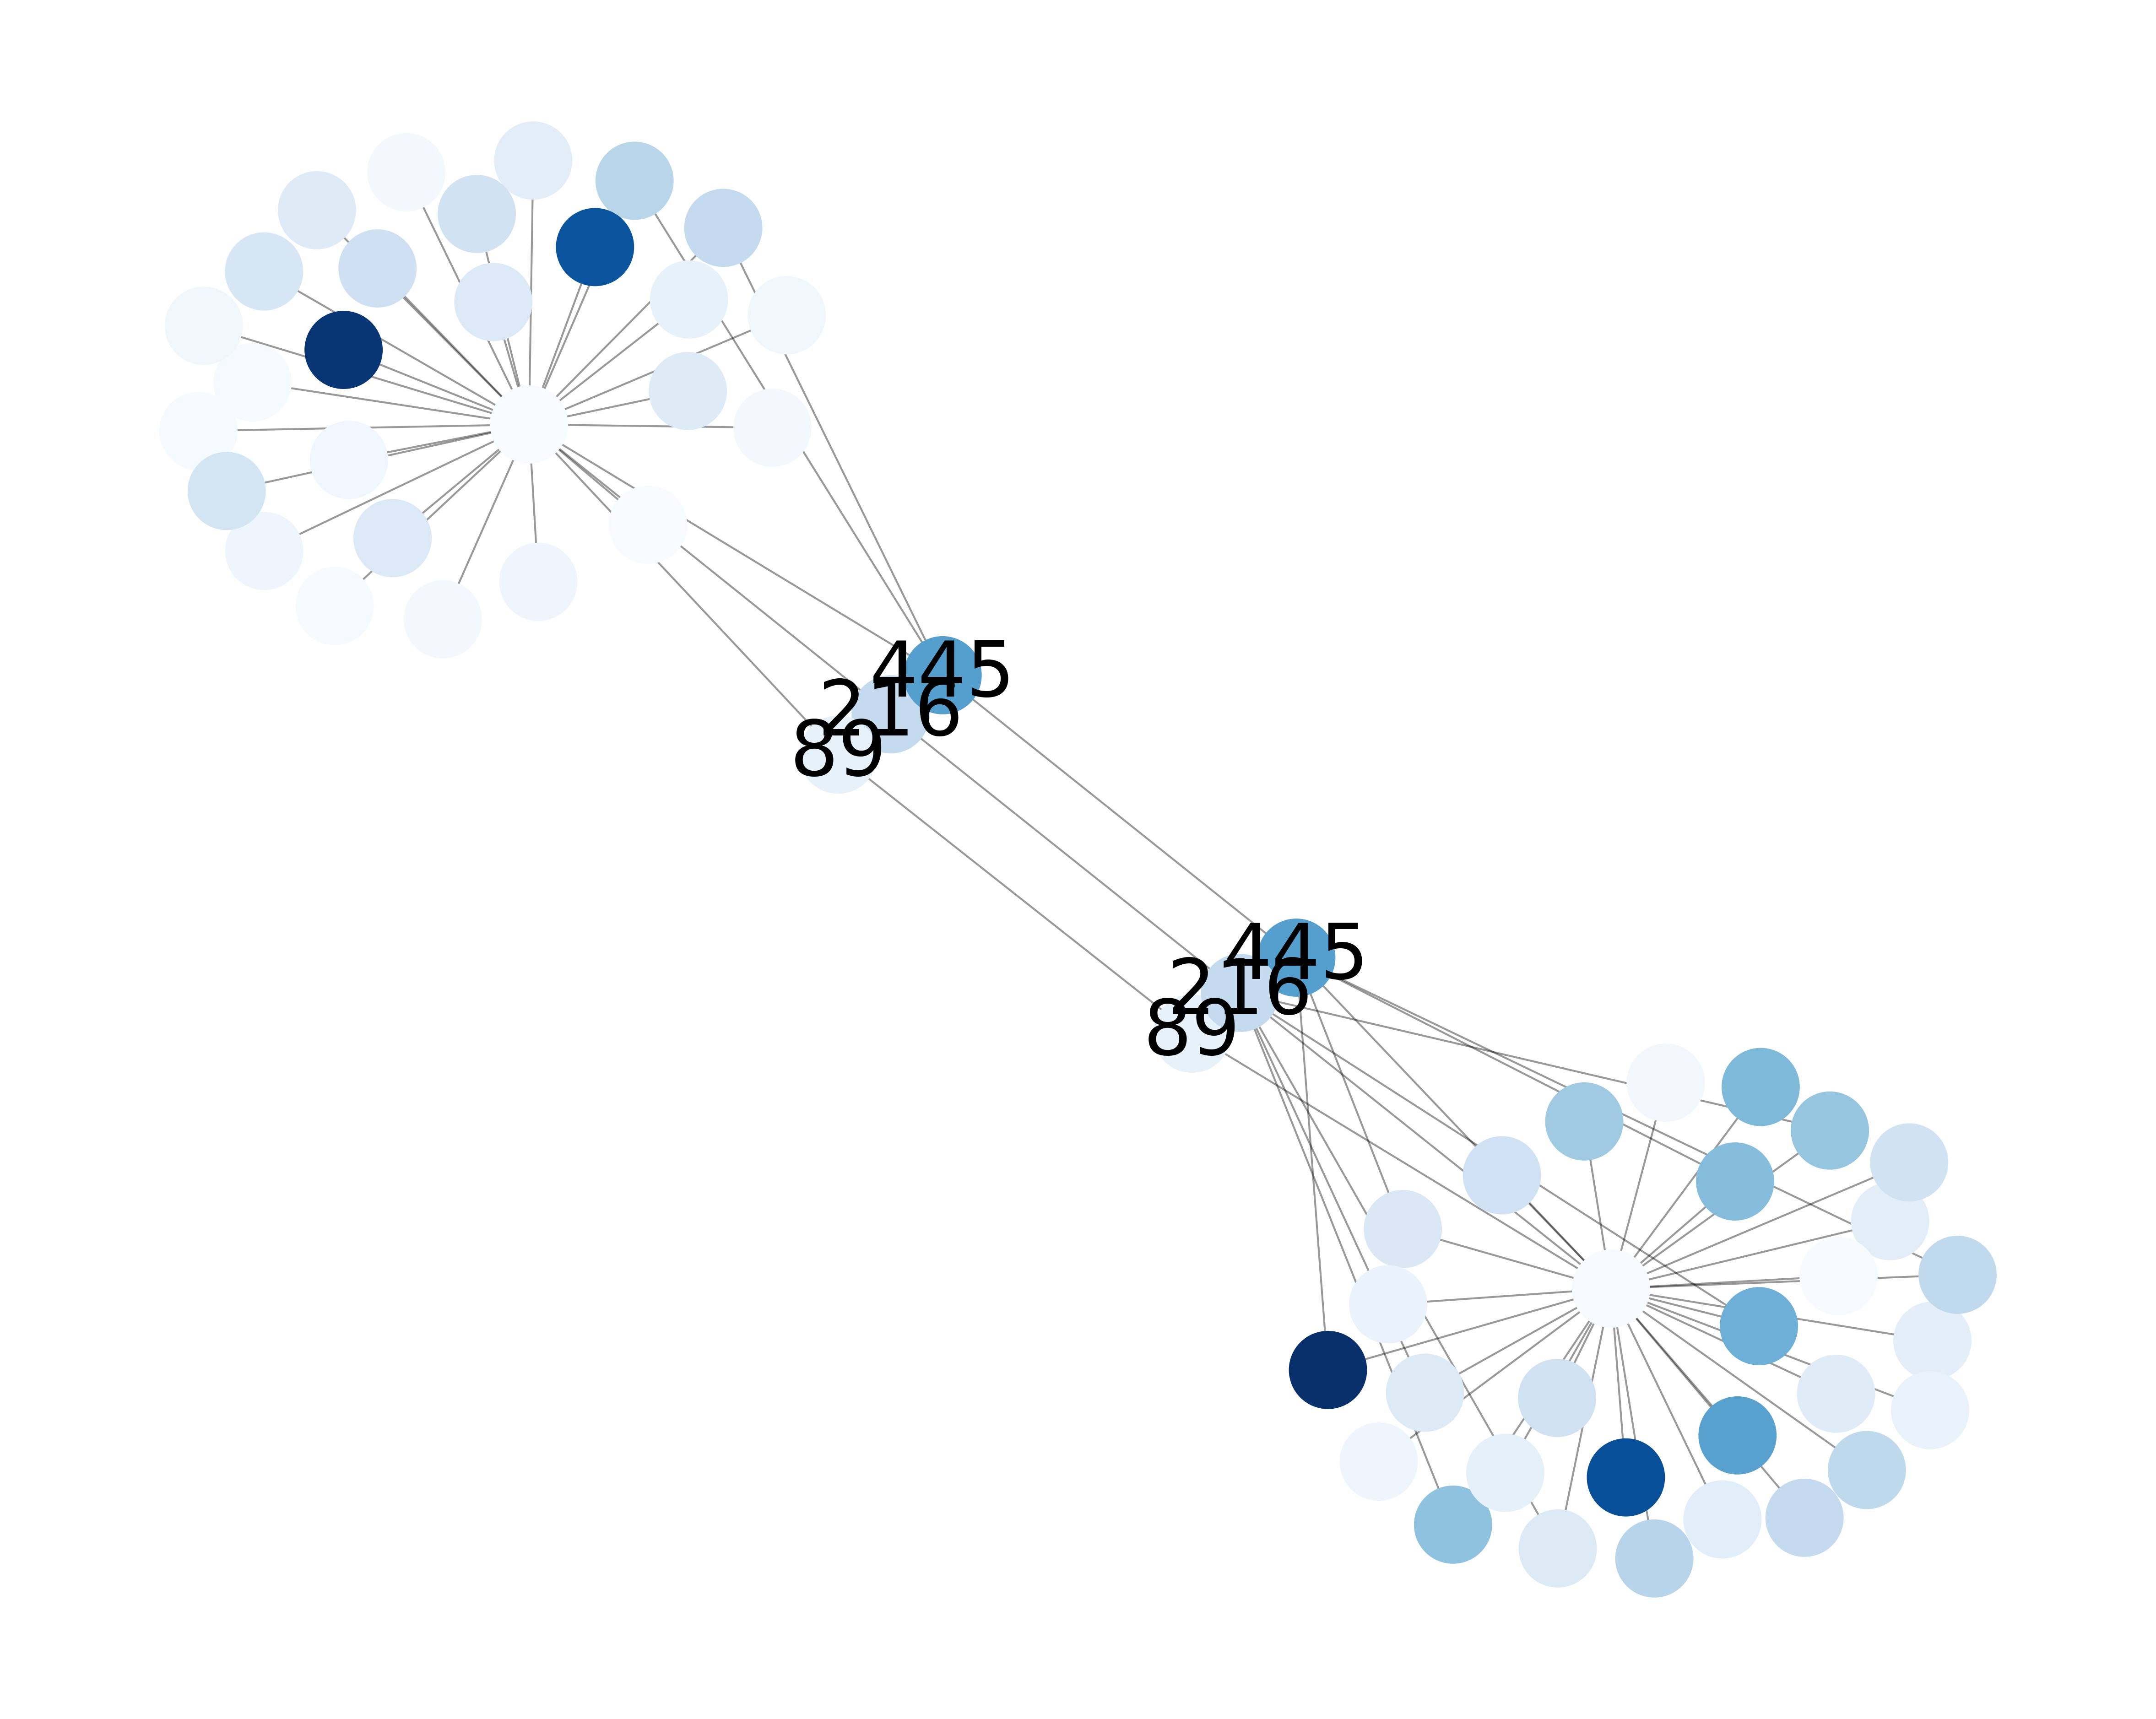

In [185]:
plot((3129, 6157))

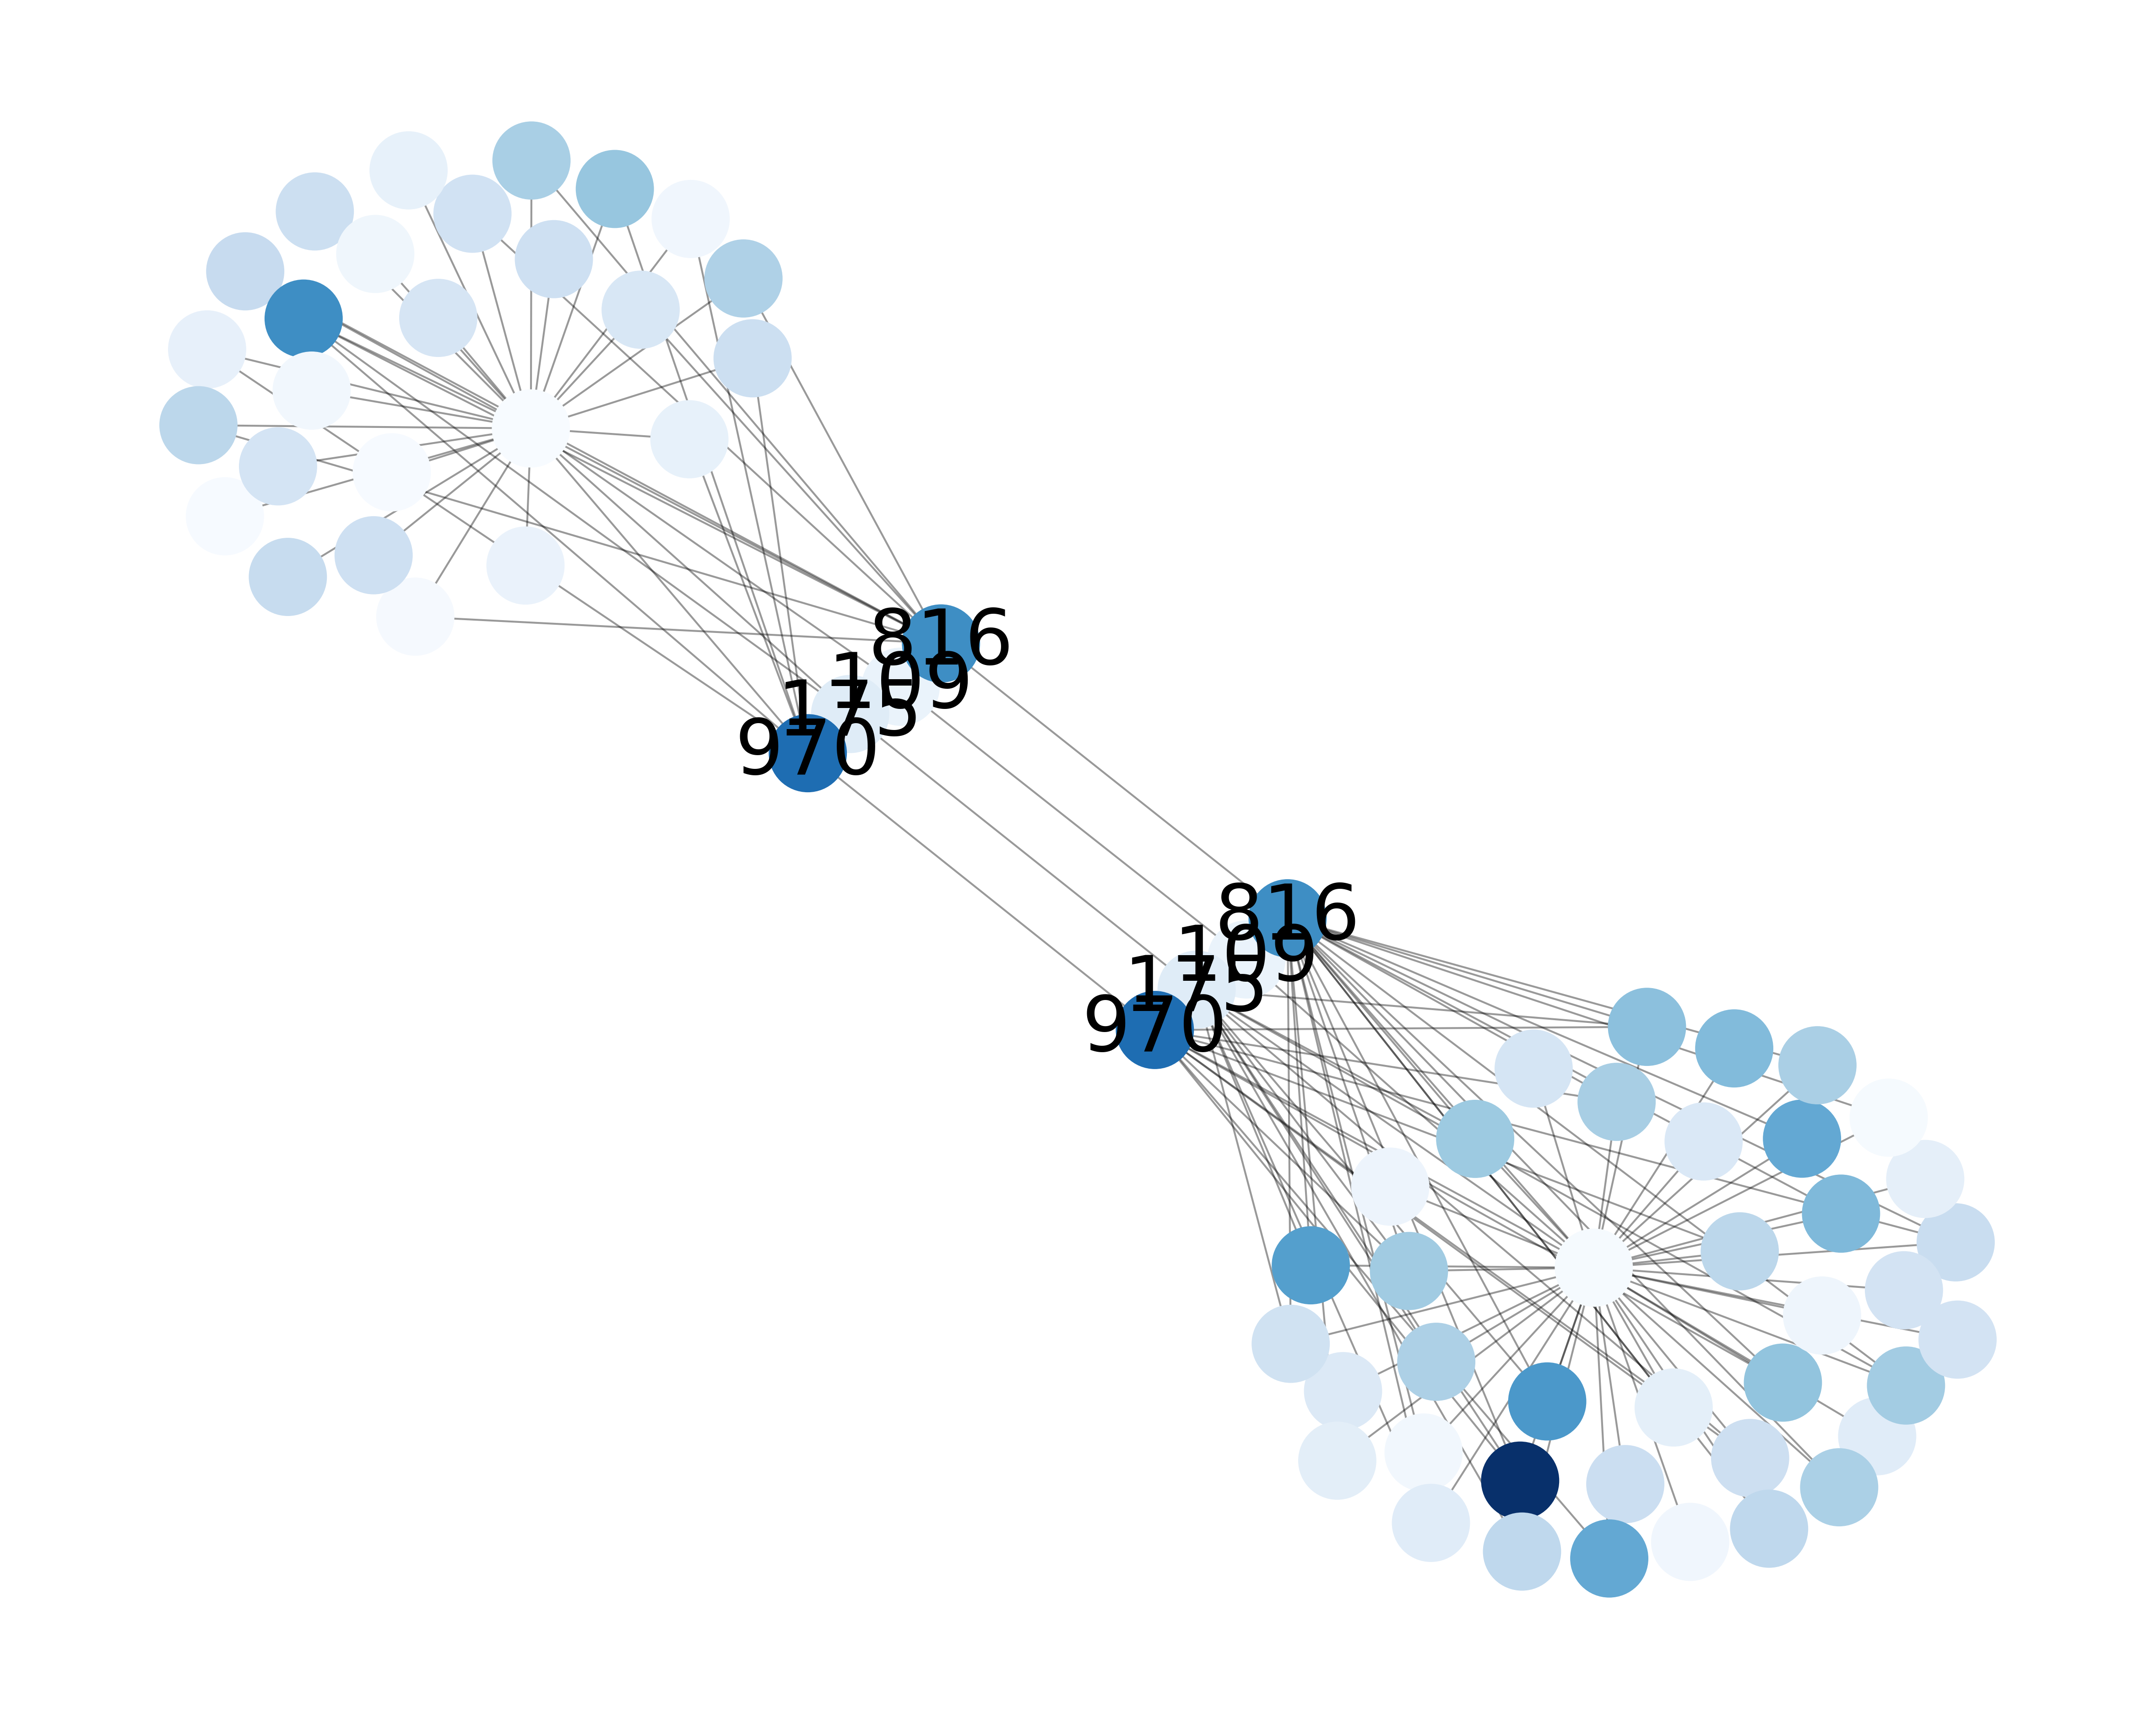

In [186]:
plot((2679, 6163))

In [187]:
plot((1834, 4970))

Output hidden; open in https://colab.research.google.com to view.

### Non-precision-1 pairs

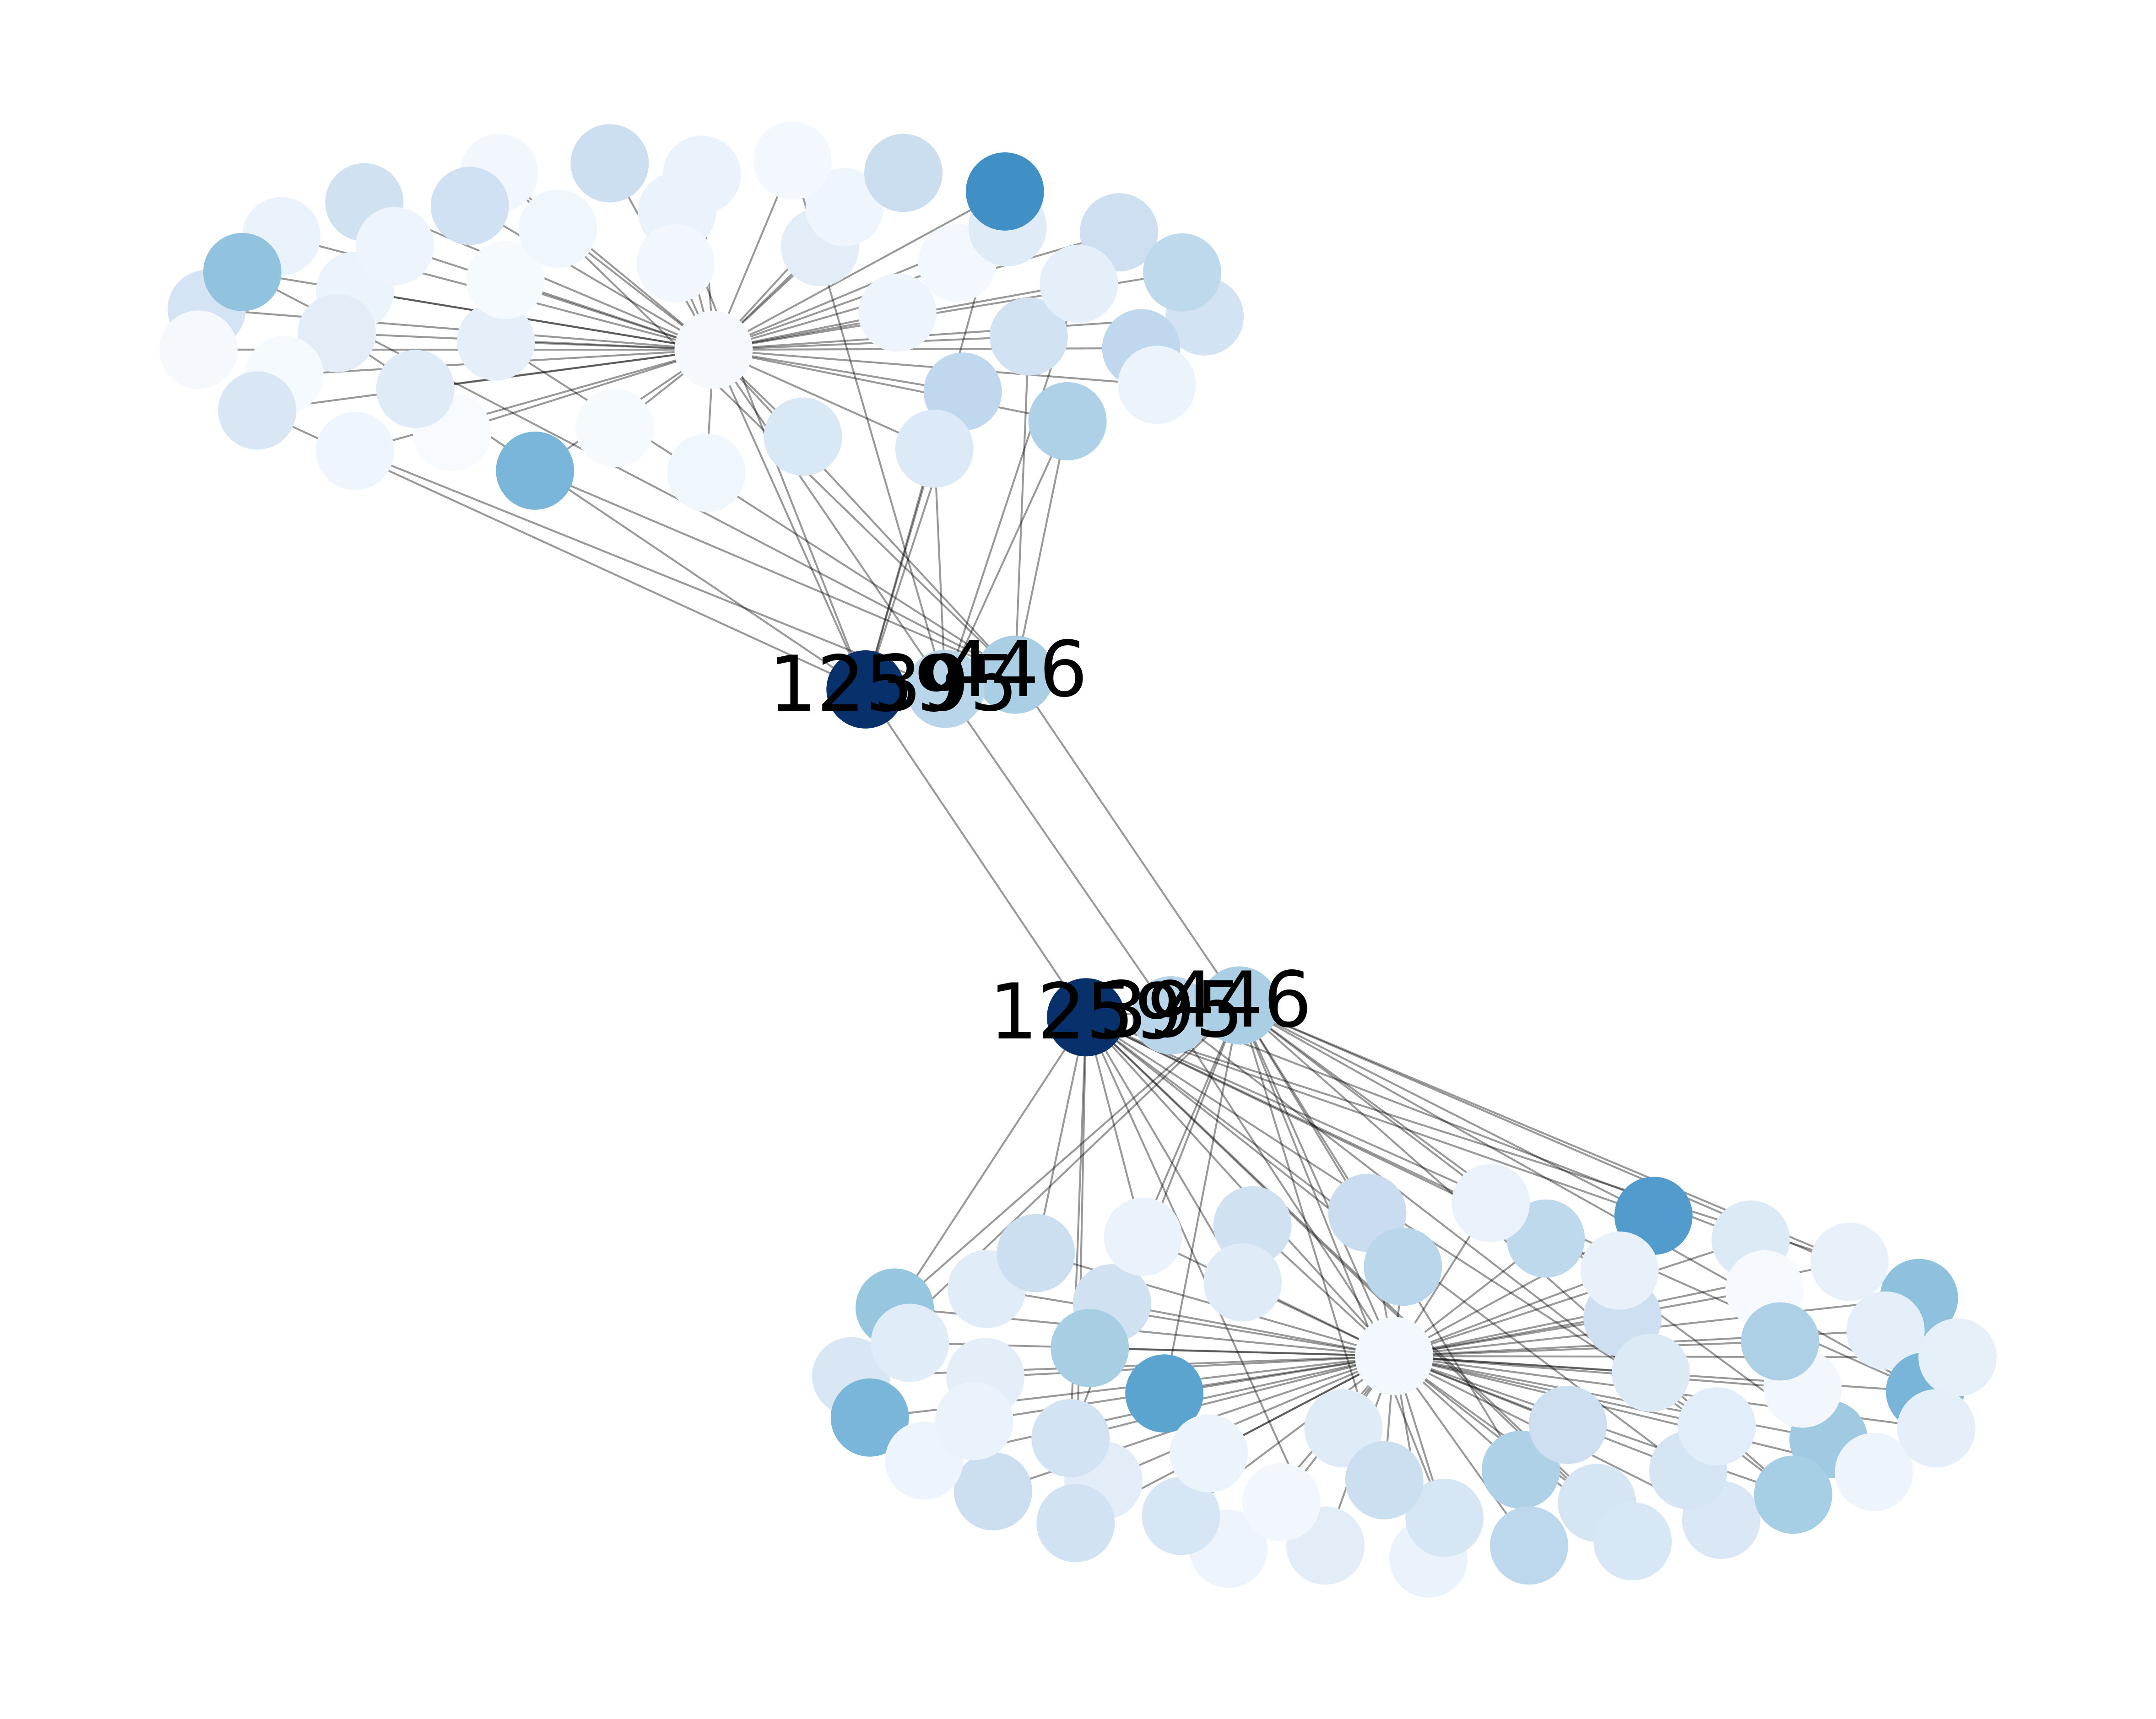

In [188]:
plot((2179, 3154))

In [189]:
plot((2839, 3157))

Output hidden; open in https://colab.research.google.com to view.

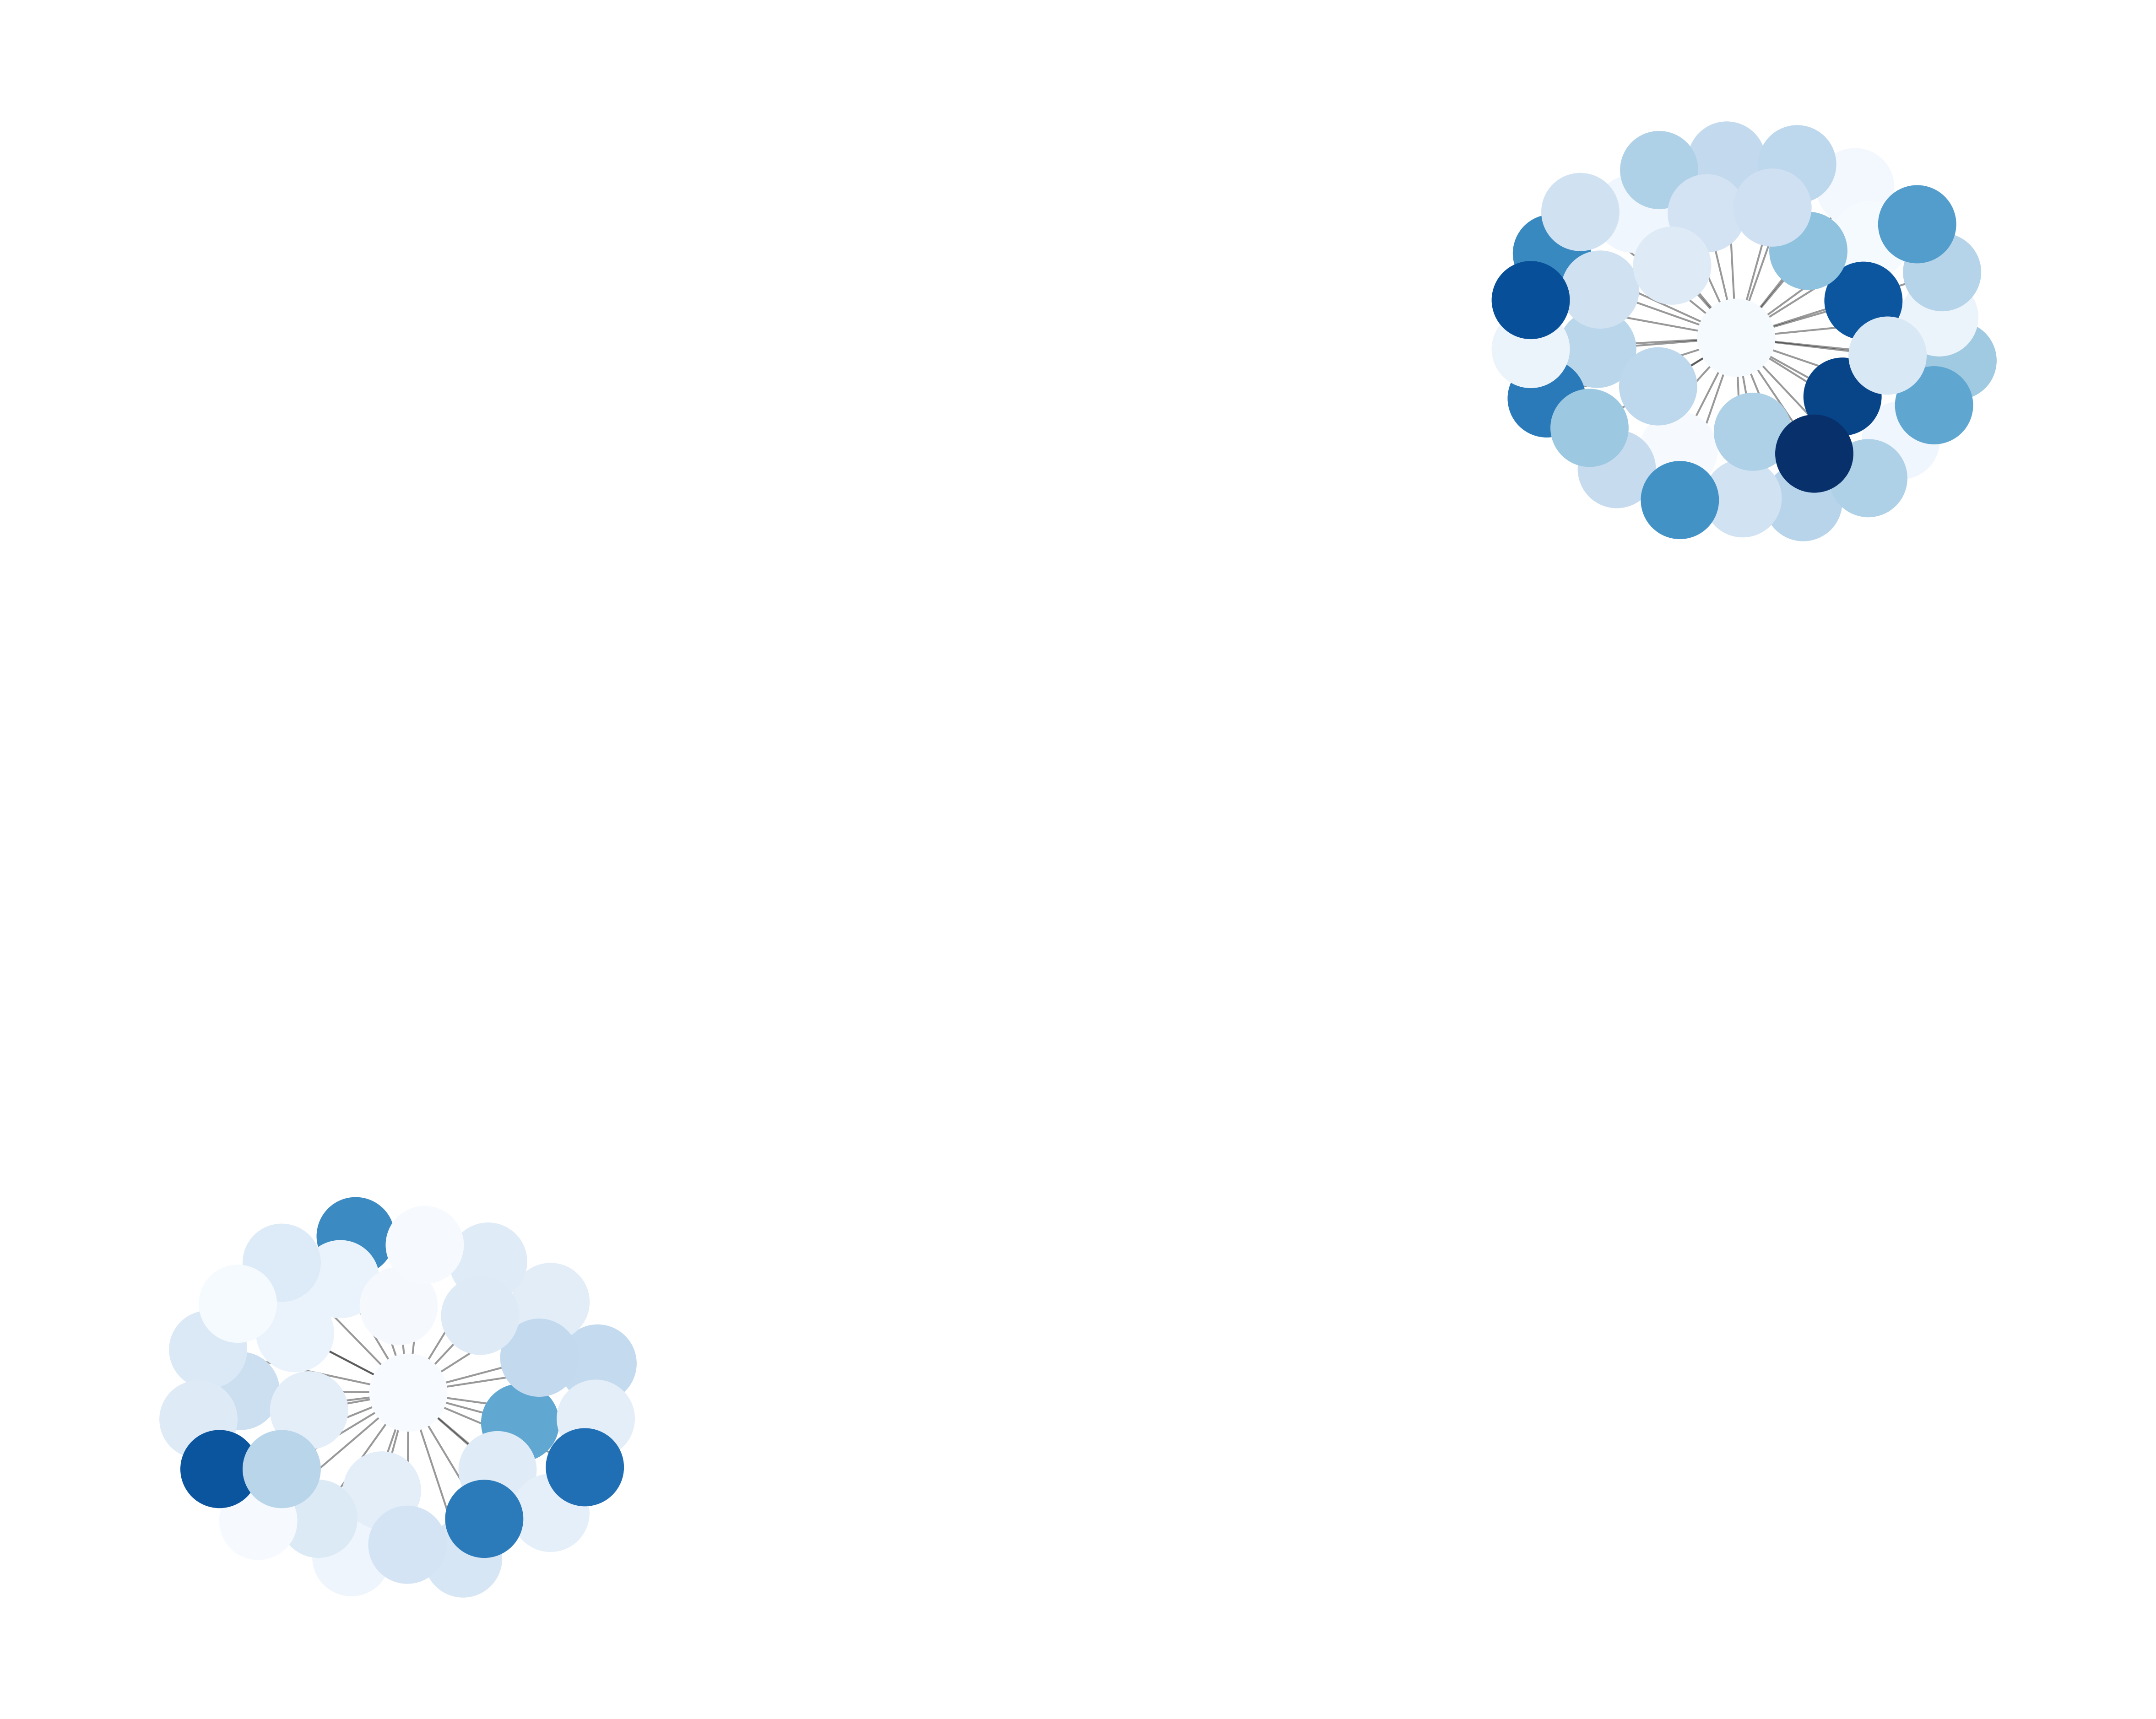

In [196]:
plot((96, 3164))

In [ ]:
states_all.real.max()

tensor(1., device='cuda:0')

In [ ]:
model

VQNE(
  (uelayers): QuantumModuleList(
    (0): UnitaryEntanglementLayer(
      (rz1): Op1QAllLayer(
        (ops_all): QuantumModuleList(
          (0):  class: RZ 
           parameters: Parameter containing:
          tensor([[-0.2554]], device='cuda:0', requires_grad=True) 
           wires: [0] 
           inverse: False
          (1):  class: RZ 
           parameters: Parameter containing:
          tensor([[-2.6837]], device='cuda:0', requires_grad=True) 
           wires: [1] 
           inverse: False
          (2):  class: RZ 
           parameters: Parameter containing:
          tensor([[-0.2115]], device='cuda:0', requires_grad=True) 
           wires: [2] 
           inverse: False
          (3):  class: RZ 
           parameters: Parameter containing:
          tensor([[2.0323]], device='cuda:0', requires_grad=True) 
           wires: [3] 
           inverse: False
          (4):  class: RZ 
           parameters: Parameter containing:
          tensor([[-1.8293]], devi

In [ ]:
for states, idx in dataloader_train:
    print(states, idx)
    break

tensor([[0.7403+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.6723+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.2982+0.j, 0.3702+0.j, 0.3702+0.j, 0.3702+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.3702+0.j, 0.3702+0.j, 0.3702+0.j, 0.2982+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.7403+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
         0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.

In [ ]:
idx_pos = [idx_dict[id.item()] for id in idx]
idx_pos

[4, 0, 2, 11, 13]

In [ ]:
states_emb = model(states)
states_pos = states_all[idx_pos]
states_pos = model(states_pos)
loss_EPE = (states_emb - states_pos)
print(loss_EPE)
print((loss_EPE.abs() ** 2).sum(-1))
loss_EPE = loss_EPE.norm() ** 2
print(loss_EPE)

tensor([[ 0.0879+0.2120j,  0.2149-0.1342j,  0.1687+0.0164j, -0.0191-0.1209j,
          0.0848-0.0339j, -0.0735+0.2594j, -0.0738+0.0924j,  0.0465+0.1303j,
          0.0209-0.1391j, -0.0693+0.0167j,  0.0154+0.1170j, -0.1087+0.2129j,
         -0.1432+0.1116j, -0.1284+0.1529j,  0.0242-0.0148j, -0.0979-0.1280j,
         -0.0126-0.0606j, -0.0010-0.2440j,  0.0033+0.1022j, -0.0255-0.0764j,
          0.1193-0.0865j, -0.1007+0.1710j, -0.1647-0.1577j, -0.0064-0.1943j,
          0.0164-0.1847j, -0.0744-0.0313j,  0.1400+0.0715j, -0.0543-0.0689j,
         -0.2038+0.0575j, -0.0769+0.1351j,  0.0437-0.2070j,  0.1228-0.0203j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j

In [ ]:
states_all = load_or_write_states(A, steps=steps)
pad = (0, 2 ** n_wires - states_all.shape[1])
states_all = F.pad(states_all, pad, 'constant', 0)
states_all = states_all.to(torch.complex64)

model = VQNE(n_wires=n_wires).to(device)
model.load_state_dict(torch.load(f'{output_path}{data}_{percentage}_qw_{steps}steps_model_weights.pt'))

FileNotFoundError: [Errno 2] No such file or directory: '../drive/MyDrive/Documents/HKUST/BDT/Courses/MSBD 5002/Project/Code/output/d2w/d2w_30_qw_2steps_model_weights.pt'

In [ ]:
(precision_10, vst_10), (precision_5, vst_5), (precision_1, vst_1) = validate(states_source, dataloader_val, model)

Precision@10: 1.0
Precision@5: 0.5555555820465088
Precision@1: 0.3333333432674408


In [ ]:
vst_5

[(9, 10), (4, 15), (3, 16), (2, 17), (1, 18)]

In [ ]:
(model(states_all[[3154]]).conj() * model(states_all[[2179]])).sum()

tensor(0.0160+4.3681e-10j, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
my_dict = {}
with torch.no_grad():
    states_3154_emb_conj = model(states_all[[3154]]).conj()
    for i in range(len(states_all)):
        my_dict[i] = (states_3154_emb_conj * model(states_all[[i]])).real.sum(-1)
my_dict = {key: value.item() for key, value in my_dict.items()}
my_df = pd.DataFrame.from_dict(my_dict, orient='index', columns=['sim'])
my_df.sort_values(by='sim')
# my_df
# (model(states_all[[3154]]).conj() * model(states_all[[2179]])).real.sum(-1)

sim
1267  6.146657e-07
2933  6.541067e-07
2135  8.820438e-07
2444  1.033678e-06
1809  1.169053e-06
...            ...
4934  2.899385e-02
4991  3.142004e-02
3570  3.163998e-02
3326  4.619049e-02
3154  9.999999e-01

[5993 rows x 1 columns]

In [ ]:
states_emb = np.array([[-1.1845e-01-0.0671j,  4.4920e-02+0.0226j, -9.8801e-03+0.0897j,
          2.0040e-01-0.1210j, -1.5857e-01-0.1639j,  6.4748e-02+0.1087j,
         -1.6380e-01+0.0208j, -1.0778e-01-0.0572j,  1.2528e-01-0.0860j,
          7.4852e-02+0.0042j,  1.8000e-01+0.0473j,  2.0455e-02+0.0680j,
         -7.1249e-02-0.2985j, -6.9654e-02+0.0330j,  1.2398e-01-0.1199j,
         -8.0576e-02+0.1682j, -1.6818e-05+0.0271j,  2.4047e-02+0.0615j,
         -5.6405e-02+0.1396j, -1.2264e-01-0.2019j, -1.0543e-01+0.1217j,
         -1.1617e-01+0.1210j, -6.3157e-02+0.1043j,  6.0524e-02-0.0616j,
         -9.2876e-02+0.0083j,  7.6030e-02+0.0047j,  2.3286e-01+0.2317j,
          9.0366e-02+0.2993j, -1.8405e-02-0.0445j,  2.7341e-02+0.4102j,
         -3.2667e-01+0.1021j, -1.3461e-01+0.0576j],
        [-1.9438e-02+0.1201j,  9.6194e-02-0.2304j, -2.4518e-01-0.0292j,
          1.1321e-01-0.0452j, -5.9684e-02-0.0038j, -7.0511e-02-0.0883j,
         -3.8722e-03-0.1743j, -6.9658e-02+0.2519j,  1.7013e-01+0.1189j,
          1.3603e-01+0.0865j,  9.3621e-02+0.0869j,  2.0673e-01+0.0207j,
         -3.8032e-02-0.1174j, -7.9713e-03+0.1597j, -3.3083e-02+0.0504j,
         -3.1316e-01-0.1046j, -3.6705e-01+0.1378j,  3.2358e-01+0.0288j,
         -1.2487e-01-0.0473j, -2.3878e-02+0.2519j, -6.9634e-02+0.0466j,
         -1.5083e-01+0.1232j, -8.8829e-02-0.0534j,  9.2426e-02+0.3532j,
          5.7323e-02-0.2232j, -1.0990e-01-0.2729j,  2.4166e-01+0.0339j,
          4.6231e-02+0.1043j, -4.8306e-02-0.0312j,  5.1066e-02+0.0481j,
         -2.0619e-01+0.0219j,  1.7991e-01+0.1775j],
        [-6.9642e-02-0.0076j,  5.8873e-02-0.0341j, -4.0955e-01+0.1535j,
         -8.0642e-02+0.2160j,  1.3863e-01+0.0144j, -1.0305e-01+0.1958j,
         -4.4437e-02+0.2084j, -2.3796e-01+0.2954j, -2.3393e-01-0.0139j,
         -2.8878e-02-0.0895j,  8.1573e-02+0.1222j, -2.2729e-02+0.0190j,
         -1.1590e-02-0.3238j,  2.1702e-01+0.1844j,  8.9931e-02-0.2114j,
          6.2564e-02-0.0173j,  4.5141e-02+0.0290j,  2.1294e-01-0.0800j,
          4.0143e-03+0.0492j, -2.8732e-01-0.0458j,  2.2663e-02-0.1588j,
          6.4423e-02+0.0841j,  1.8980e-01-0.0787j,  1.8470e-01+0.0799j,
          7.8977e-02-0.0914j,  1.1283e-01+0.1168j, -5.0144e-02-0.1348j,
         -1.4003e-01+0.2194j,  2.8530e-02+0.3105j, -9.3245e-02+0.1235j,
         -1.9021e-01+0.1083j, -7.5580e-02+0.0292j],
        [ 1.8743e-02+0.0040j,  2.3576e-01-0.0107j, -1.7456e-01-0.0080j,
          1.2164e-01-0.1293j, -2.3333e-01+0.0919j,  6.3836e-02-0.0821j,
         -2.1378e-01+0.0361j, -2.4254e-02-0.0762j,  4.9852e-02-0.0631j,
          1.8097e-02-0.0557j,  8.3481e-02+0.0271j, -1.4950e-01+0.0312j,
         -1.3522e-01-0.1232j,  1.3382e-01+0.0897j, -5.8734e-02+0.0400j,
          1.0757e-01-0.2795j,  1.6121e-01+0.1194j,  5.0030e-02-0.1731j,
         -6.3895e-02-0.0957j, -6.9410e-02+0.1069j, -2.8542e-01+0.0723j,
          8.4150e-02+0.0885j,  1.8148e-03-0.1367j,  4.6866e-02+0.0728j,
         -5.6098e-02-0.2513j,  1.9744e-01+0.0149j,  1.4680e-01+0.0048j,
          1.7624e-01+0.0758j, -1.6636e-01+0.0242j, -1.0743e-01-0.0579j,
         -3.9545e-01-0.1409j, -2.0196e-01-0.1512j],
        [-7.8020e-02-0.1295j,  7.8279e-02+0.0395j, -1.4113e-01+0.2214j,
          3.1783e-01-0.1167j, -2.4092e-01-0.0556j,  9.2461e-02+0.0443j,
         -6.6757e-03+0.1472j, -9.0837e-02-0.0286j,  6.7141e-02+0.0325j,
         -2.4759e-02-0.0762j,  2.5179e-01+0.0660j, -6.2627e-02+0.0747j,
         -2.1874e-01-0.3020j, -1.5082e-01+0.0821j,  1.3619e-01-0.3521j,
         -2.0215e-01+0.1951j,  1.0109e-01+0.0282j,  1.5237e-01+0.1551j,
          1.6861e-02+0.1394j, -1.1379e-01-0.3635j, -1.5185e-01+0.1145j,
         -2.1777e-01+0.1571j, -1.4890e-02+0.0600j,  6.1544e-02+0.0408j,
         -7.0473e-02-0.1113j, -1.8273e-02-0.0643j,  3.9881e-01+0.2123j,
          2.3818e-01+0.3846j, -1.5290e-01-0.0466j, -1.9538e-01+0.3630j,
         -4.8212e-01+0.0380j, -6.0215e-02+0.0053j]])
states_emb = torch.complex(real=torch.Tensor(states_emb.real), imag=torch.Tensor(states_emb.imag))

states_neg = np.array([[[-0.3231-0.0278j, -0.0066-0.2044j, -0.4042+0.0550j,  0.0096-0.0037j,
          -0.1681-0.1251j, -0.1488+0.1190j, -0.0339+0.0013j, -0.0554-0.0528j,
           0.1869+0.1140j,  0.0646+0.1509j,  0.3103-0.0501j,  0.4592+0.0404j,
          -0.2052-0.1416j, -0.1080+0.1065j,  0.0752-0.2811j, -0.1665+0.1238j,
           0.2572-0.0521j,  0.1940-0.0554j,  0.1328+0.0381j, -0.1099-0.0234j,
          -0.1444-0.0874j, -0.2564-0.0007j,  0.2690-0.1861j, -0.0639-0.1576j,
          -0.2383-0.2178j,  0.0871-0.0136j,  0.1927+0.0381j,  0.2718+0.1415j,
          -0.2430+0.0442j, -0.2467-0.2662j, -0.3612-0.1259j, -0.2029+0.0641j],
         [ 0.0175+0.0522j,  0.0078-0.1934j, -0.2446-0.0308j,  0.0844-0.0464j,
          -0.0658+0.0289j, -0.1220-0.0714j,  0.0324-0.2414j, -0.0748+0.3459j,
           0.2137+0.1129j,  0.1776+0.0230j,  0.0521+0.0489j,  0.1639-0.0512j,
          -0.0775-0.0715j,  0.0615+0.1421j, -0.0336+0.0673j, -0.2658-0.1511j,
          -0.2947+0.1332j,  0.3558-0.0057j, -0.1089+0.0519j, -0.1330+0.1041j,
          -0.1501+0.1203j, -0.2070+0.0921j, -0.0606+0.0970j,  0.0266+0.3605j,
          -0.0175-0.2590j, -0.0813-0.3477j,  0.2528+0.0628j,  0.0479+0.1036j,
           0.0538+0.0072j,  0.0364+0.0095j, -0.1134-0.0436j,  0.0392+0.1584j],
         [-0.0849+0.0395j,  0.0091+0.0030j, -0.3817+0.1126j, -0.0580+0.2006j,
           0.1477+0.0196j, -0.0680+0.1575j, -0.0623+0.1986j, -0.2046+0.2104j,
          -0.1829-0.0129j, -0.0364-0.1072j,  0.0973+0.1042j, -0.0129+0.0795j,
          -0.0116-0.2793j,  0.2004+0.1512j,  0.0752-0.1779j,  0.0931-0.0103j,
          -0.0310+0.0709j,  0.2310-0.1375j, -0.0045+0.0651j, -0.2498-0.0269j,
           0.0130-0.1141j,  0.0651-0.0487j,  0.1698-0.0550j,  0.1191+0.0505j,
           0.0658-0.0403j,  0.0981+0.0640j, -0.0193-0.1131j, -0.1249+0.1270j,
           0.0446+0.2454j, -0.1028+0.1522j, -0.1707+0.0895j, -0.0406-0.0139j],
         [ 0.0822-0.0496j,  0.3215-0.0690j, -0.3461+0.1086j,  0.1964-0.1471j,
          -0.2652+0.1615j,  0.0640-0.0680j, -0.1702-0.0304j, -0.0725+0.0100j,
           0.0458-0.0143j, -0.0174+0.0221j,  0.2839+0.0361j, -0.0693+0.0466j,
          -0.1796-0.0484j,  0.0979+0.1031j,  0.1100+0.0107j,  0.1380-0.2351j,
           0.1447+0.0518j,  0.0621-0.2512j, -0.0318-0.0903j, -0.1587-0.0423j,
          -0.5248+0.0201j,  0.0258+0.0289j,  0.0544-0.0691j,  0.0922+0.1942j,
          -0.0970-0.1531j,  0.2032+0.1090j,  0.1925+0.0055j,  0.3363+0.3199j,
          -0.4055-0.0399j, -0.2197-0.1478j, -0.5130-0.0687j, -0.1283-0.0076j],
         [-0.0211+0.0342j,  0.2758+0.0607j, -0.0939+0.0808j,  0.1270+0.1684j,
          -0.2537+0.0986j, -0.0077-0.0955j, -0.1331+0.0088j, -0.1535+0.1724j,
           0.0731+0.3219j,  0.0532-0.0944j,  0.2830-0.0123j,  0.0567+0.1203j,
          -0.1089+0.1014j, -0.1041+0.2845j,  0.0862-0.2451j, -0.0388+0.2045j,
           0.0078+0.0683j, -0.0635-0.0880j, -0.0252+0.4200j, -0.0431+0.2651j,
           0.0439-0.0712j, -0.1265+0.0488j,  0.0590+0.2137j, -0.1499+0.0979j,
          -0.1789-0.2966j,  0.0410+0.0803j,  0.0857+0.0289j,  0.3017+0.4478j,
          -0.2992+0.2382j, -0.3887+0.0196j, -0.3511-0.0943j, -0.1441+0.1012j]],

        [[-0.3231-0.0278j, -0.0066-0.2044j, -0.4042+0.0550j,  0.0096-0.0037j,
          -0.1681-0.1251j, -0.1488+0.1190j, -0.0339+0.0013j, -0.0554-0.0528j,
           0.1869+0.1140j,  0.0646+0.1509j,  0.3103-0.0501j,  0.4592+0.0404j,
          -0.2052-0.1416j, -0.1080+0.1065j,  0.0752-0.2811j, -0.1665+0.1238j,
           0.2572-0.0521j,  0.1940-0.0554j,  0.1328+0.0381j, -0.1099-0.0234j,
          -0.1444-0.0874j, -0.2564-0.0007j,  0.2690-0.1861j, -0.0639-0.1576j,
          -0.2383-0.2178j,  0.0871-0.0136j,  0.1927+0.0381j,  0.2718+0.1415j,
          -0.2430+0.0442j, -0.2467-0.2662j, -0.3612-0.1259j, -0.2029+0.0641j],
         [-0.1644-0.0109j, -0.2780-0.2089j, -0.2403-0.1116j,  0.0131-0.1655j,
          -0.1378-0.0860j,  0.0126+0.1185j, -0.1311+0.0645j, -0.0935+0.0618j,
           0.1477+0.0137j, -0.0732+0.1908j,  0.1809-0.0751j,  0.2908+0.0121j,
          -0.1480-0.1310j, -0.0674+0.0554j, -0.0122-0.1686j, -0.1973+0.0636j,
           0.1529-0.0815j,  0.1319-0.0477j,  0.0461+0.0411j, -0.1076+0.0797j,
          -0.0442-0.1568j, -0.2100-0.0804j,  0.2315-0.1516j, -0.0415-0.0916j,
          -0.1602-0.1537j,  0.0717+0.0620j,  0.0318+0.0129j,  0.1812+0.0449j,
          -0.1665-0.0257j, -0.1965-0.0997j, -0.1692-0.1282j, -0.2006-0.0017j],
         [-0.1752-0.1813j,  0.0872-0.0955j,  0.0979+0.0164j, -0.0656+0.0077j,
           0.0151+0.0508j, -0.2048+0.2530j, -0.0514+0.0524j, -0.1577+0.1787j,
          -0.0496+0.0475j, -0.0483-0.0331j,  0.0859+0.1780j,  0.1299+0.0719j,
          -0.3015-0.0662j,  0.0126+0.0425j,  0.1787-0.1591j,  0.1774+0.0511j,
          -0.1510-0.0029j,  0.0957-0.1244j,  0.0579+0.0550j,  0.2396+0.1009j,
          -0.2076+0.0241j, -0.1431+0.1683j, -0.0992-0.0239j,  0.0244+0.0863j,
           0.1491-0.0197j,  0.0054-0.0363j,  0.1913-0.0740j,  0.2380+0.0823j,
          -0.1312-0.1670j, -0.2571+0.0764j, -0.1318-0.1291j, -0.2793-0.0553j],
         [-0.3231-0.0278j, -0.0066-0.2044j, -0.4042+0.0550j,  0.0096-0.0037j,
          -0.1681-0.1251j, -0.1488+0.1190j, -0.0339+0.0013j, -0.0554-0.0528j,
           0.1869+0.1140j,  0.0646+0.1509j,  0.3103-0.0501j,  0.4592+0.0404j,
          -0.2052-0.1416j, -0.1080+0.1065j,  0.0752-0.2811j, -0.1665+0.1238j,
           0.2572-0.0521j,  0.1940-0.0554j,  0.1328+0.0381j, -0.1099-0.0234j,
          -0.1444-0.0874j, -0.2564-0.0007j,  0.2690-0.1861j, -0.0639-0.1576j,
          -0.2383-0.2178j,  0.0871-0.0136j,  0.1927+0.0381j,  0.2718+0.1415j,
          -0.2430+0.0442j, -0.2467-0.2662j, -0.3612-0.1259j, -0.2029+0.0641j],
         [-0.0849+0.0395j,  0.0091+0.0030j, -0.3817+0.1126j, -0.0580+0.2006j,
           0.1477+0.0196j, -0.0680+0.1575j, -0.0623+0.1986j, -0.2046+0.2104j,
          -0.1829-0.0129j, -0.0364-0.1072j,  0.0973+0.1042j, -0.0129+0.0795j,
          -0.0116-0.2793j,  0.2004+0.1512j,  0.0752-0.1779j,  0.0931-0.0103j,
          -0.0310+0.0709j,  0.2310-0.1375j, -0.0045+0.0651j, -0.2498-0.0269j,
           0.0130-0.1141j,  0.0651-0.0487j,  0.1698-0.0550j,  0.1191+0.0505j,
           0.0658-0.0403j,  0.0981+0.0640j, -0.0193-0.1131j, -0.1249+0.1270j,
           0.0446+0.2454j, -0.1028+0.1522j, -0.1707+0.0895j, -0.0406-0.0139j]]])
states_neg = torch.complex(real=torch.Tensor(states_neg.real), imag=torch.Tensor(states_neg.imag))

states_pos = np.array([[ 0.0085-0.0434j, -0.1045-0.0283j, -0.0738+0.1250j,  0.0626+0.1945j,
         -0.1192-0.0559j,  0.0389-0.2195j, -0.0237-0.0569j,  0.0472+0.0940j,
          0.1193+0.0377j, -0.0779-0.1410j,  0.1156+0.2487j,  0.2180-0.0932j,
          0.0352-0.0541j,  0.0842-0.3057j,  0.0617-0.1042j, -0.0660+0.0861j,
         -0.1106-0.0266j,  0.0216+0.1195j, -0.0476+0.0583j, -0.0932+0.0472j,
         -0.1175-0.1385j, -0.0416+0.0349j,  0.0601+0.1093j, -0.0621+0.0662j,
          0.1172-0.0656j,  0.1729+0.1494j,  0.3540-0.2058j,  0.1596+0.0341j,
         -0.1167+0.0889j, -0.0811-0.0538j, -0.4196+0.0800j, -0.2553-0.0856j],
        [-0.0696-0.0076j,  0.0589-0.0341j, -0.4095+0.1535j, -0.0806+0.2160j,
          0.1386+0.0144j, -0.1031+0.1958j, -0.0444+0.2084j, -0.2380+0.2954j,
         -0.2339-0.0139j, -0.0289-0.0895j,  0.0816+0.1222j, -0.0227+0.0190j,
         -0.0116-0.3238j,  0.2170+0.1844j,  0.0899-0.2114j,  0.0626-0.0173j,
          0.0451+0.0290j,  0.2129-0.0800j,  0.0040+0.0492j, -0.2873-0.0458j,
          0.0227-0.1588j,  0.0644+0.0841j,  0.1898-0.0787j,  0.1847+0.0799j,
          0.0790-0.0914j,  0.1128+0.1168j, -0.0501-0.1348j, -0.1400+0.2194j,
          0.0285+0.3105j, -0.0932+0.1235j, -0.1902+0.1083j, -0.0756+0.0292j],
        [-0.0194+0.1201j,  0.0962-0.2304j, -0.2452-0.0292j,  0.1132-0.0452j,
         -0.0597-0.0038j, -0.0705-0.0883j, -0.0039-0.1743j, -0.0697+0.2519j,
          0.1701+0.1189j,  0.1360+0.0865j,  0.0936+0.0869j,  0.2067+0.0207j,
         -0.0380-0.1174j, -0.0080+0.1597j, -0.0331+0.0504j, -0.3132-0.1046j,
         -0.3670+0.1378j,  0.3236+0.0288j, -0.1249-0.0473j, -0.0239+0.2519j,
         -0.0696+0.0466j, -0.1508+0.1232j, -0.0888-0.0534j,  0.0924+0.3532j,
          0.0573-0.2232j, -0.1099-0.2729j,  0.2417+0.0339j,  0.0462+0.1043j,
         -0.0483-0.0312j,  0.0511+0.0481j, -0.2062+0.0219j,  0.1799+0.1775j],
        [-0.0378+0.0492j,  0.2021+0.0480j, -0.0922+0.0052j,  0.0766+0.2087j,
         -0.0856-0.0269j, -0.0242-0.2286j, -0.1757-0.0493j, -0.1707+0.1301j,
          0.0385+0.1672j,  0.1494-0.0902j,  0.2104+0.0566j, -0.0846-0.0135j,
         -0.0551+0.0466j, -0.0321+0.2147j,  0.0126-0.2724j, -0.0806+0.1371j,
         -0.0157-0.0256j, -0.0752-0.1027j, -0.0574+0.3043j,  0.0260+0.1947j,
          0.1061-0.0343j, -0.0680-0.0736j,  0.0221+0.0836j, -0.1280+0.1272j,
         -0.1693-0.1728j, -0.0343+0.0811j, -0.0912+0.0080j,  0.3578+0.2232j,
         -0.2043+0.0617j, -0.1304+0.1122j, -0.1319-0.0683j, -0.2030+0.0144j],
        [ 0.0618-0.0684j, -0.0361+0.0232j, -0.1038+0.2504j,  0.0876+0.2299j,
         -0.1639+0.0309j, -0.0429-0.0675j, -0.0244-0.1341j,  0.0620+0.0510j,
          0.1048+0.1062j, -0.1452-0.0246j,  0.1545+0.3267j,  0.2196-0.1171j,
         -0.0764-0.1309j,  0.0821+0.0347j, -0.0010-0.2403j, -0.2662+0.1102j,
         -0.1148-0.0048j, -0.0566+0.0490j,  0.0146+0.0703j, -0.0502-0.0281j,
         -0.2244-0.1186j, -0.0720-0.0739j,  0.1664+0.1659j, -0.0699+0.0865j,
          0.1667-0.1289j,  0.2662+0.1965j,  0.6073-0.1851j,  0.2609+0.1801j,
         -0.1891+0.1136j, -0.1567-0.1766j, -0.5923+0.1099j, -0.3044+0.0312j]])
states_pos = torch.complex(real=torch.Tensor(states_pos.real), imag=torch.Tensor(states_pos.imag))

inner_prod_neg = (states_emb.conj() * states_neg).real.sum(-1)
print(f'inner_prod_neg: {inner_prod_neg}')

inner_prod_pos = (states_emb.conj() * states_pos).real.sum(-1)
inner_prod_pos = inner_prod_pos.expand([states_neg.shape[0], -1])
print(f'inner_prod_pos: {inner_prod_pos}')

zeros = torch.zeros(inner_prod_neg.shape).to(states_emb.device)
print(f'zeros: {zeros}')

loss_MT = torch.maximum(inner_prod_neg - inner_prod_pos + 0.07, zeros)
print(f'loss_MT: {loss_MT}')
loss_MT = loss_MT.sum(-1)
print(f'loss_MT: {loss_MT}')
loss_MT = loss_MT.mean()
print(f'loss_MT: {loss_MT}')

loss_EPE = (states_emb - states_pos)
# print(f'loss_EPE: {loss_EPE}')
loss_EPE = (loss_EPE.abs() ** 2).sum()#.norm() ** 2
print(f'loss_EPE: {loss_EPE}')

print((states_emb - states_neg).shape)

# inner_prod_neg = np.array([[0.5313, 1.2963, 1.1875, 1.2813, 1.0000],
#                             [0.5313, 0.2535, 0.2535, 0.5313, 0.3542]])
# inner_prod_neg = torch.Tensor(inner_prod_neg)
# inner_prod_pos = np.array([[0.3047, 0.1975, 0.1975, 0.3047, 1.0000],
#                             [0.3047, 0.1975, 0.1975, 0.3047, 1.0000]])
# inner_prod_pos = torch.Tensor(inner_prod_pos)

# zeros = torch.zeros(inner_prod_neg.shape)
# loss_MT = torch.maximum(inner_prod_neg - inner_prod_pos + 0.07, zeros)
# print(loss_MT)
# loss_MT = loss_MT.sum(-1).mean()
# print(loss_MT)


inner_prod_neg: tensor([[0.5313, 1.2964, 1.1875, 1.2812, 1.0000],
        [0.5313, 0.2535, 0.2534, 0.5312, 0.3543]])
inner_prod_pos: tensor([[0.3047, 0.1976, 0.1976, 0.3046, 1.0000],
        [0.3047, 0.1976, 0.1976, 0.3046, 1.0000]])
zeros: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
loss_MT: tensor([[0.2966, 1.1688, 1.0599, 1.0466, 0.0700],
        [0.2966, 0.1259, 0.1259, 0.2966, 0.0000]])
loss_MT: tensor([3.6417, 0.8449])
loss_MT: 2.2433114051818848
loss_EPE: 10.089064598083496
torch.Size([2, 5, 32])


In [ ]:
states_emb[0].abs() ** 2

tensor([0.0185, 0.0025, 0.0081, 0.0548, 0.0520, 0.0160, 0.0273, 0.0149, 0.0231,
        0.0056, 0.0346, 0.0050, 0.0942, 0.0059, 0.0297, 0.0348, 0.0007, 0.0044,
        0.0227, 0.0558, 0.0259, 0.0281, 0.0149, 0.0075, 0.0087, 0.0058, 0.1079,
        0.0977, 0.0023, 0.1690, 0.1171, 0.0214])

In [ ]:
states_emb_bsz = states_emb.shape[0]
states_emb_n_wires = states_emb.shape[1]

states_emb_norm = (states_emb.abs() ** 2).sum(axis=1).sqrt()
states_emb_norm = states_emb_norm.reshape([states_emb_bsz, 1])
states_emb_norm = states_emb_norm.expand(-1, states_emb_n_wires)
states_emb_normed = states_emb / states_emb_norm
print((states_emb_normed.abs() ** 2).sum(axis=1))
print(states_emb_normed[0].norm())

print(states_emb[0])
print((states_emb[0].abs() ** 2).sum().sqrt())
print(states_emb[0].norm())
print((states_emb[0] / states_emb[0].norm()))
print((states_emb[0] / states_emb[0].norm()).norm())

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor([-1.1845e-01-0.0671j,  4.4920e-02+0.0226j, -9.8801e-03+0.0897j,
         2.0040e-01-0.1210j, -1.5857e-01-0.1639j,  6.4748e-02+0.1087j,
        -1.6380e-01+0.0208j, -1.0778e-01-0.0572j,  1.2528e-01-0.0860j,
         7.4852e-02+0.0042j,  1.8000e-01+0.0473j,  2.0455e-02+0.0680j,
        -7.1249e-02-0.2985j, -6.9654e-02+0.0330j,  1.2398e-01-0.1199j,
        -8.0576e-02+0.1682j, -1.6818e-05+0.0271j,  2.4047e-02+0.0615j,
        -5.6405e-02+0.1396j, -1.2264e-01-0.2019j, -1.0543e-01+0.1217j,
        -1.1617e-01+0.1210j, -6.3157e-02+0.1043j,  6.0524e-02-0.0616j,
        -9.2876e-02+0.0083j,  7.6030e-02+0.0047j,  2.3286e-01+0.2317j,
         9.0366e-02+0.2993j, -1.8405e-02-0.0445j,  2.7341e-02+0.4102j,
        -3.2667e-01+0.1021j, -1.3461e-01+0.0576j])
tensor(1.0570)
tensor(1.0570)
tensor([-1.1206e-01-0.0635j,  4.2498e-02+0.0214j, -9.3474e-03+0.0849j,
         1.8959e-01-0.1145j, -1.5002e-01-0.1551j,  6.1257e-02+0.1028j,
   

In [ ]:
idx_all = np.array(range(states_all.shape[0]))

for idx in range(states_all.shape[0]):
    idx_others = np.delete(idx_all, idx)
    print(f'sim between {idx} and others:\n {(states_all[idx].conj() * states_all).sum(axis=1).abs()}')

sim between 0 and others:
 tensor([0.2319, 0.1713, 0.2014, 0.2014, 0.2014, 0.1682, 0.1682, 0.1528, 0.1528,
        0.1528, 0.1528, 0.1528, 0.1528, 0.1682, 0.1682, 0.2014, 0.2014, 0.2014,
        0.1713], device='cuda:0')
sim between 1 and others:
 tensor([0.1713, 1.0660, 0.2135, 0.2135, 0.2135, 1.1875, 1.1875, 0.3542, 0.3542,
        0.3542, 0.3542, 0.3542, 0.3542, 0.1690, 0.1690, 0.2135, 0.2135, 0.2135,
        0.1493], device='cuda:0')
sim between 2 and others:
 tensor([0.2014, 0.2135, 1.1172, 0.3047, 0.3047, 0.2535, 0.2535, 1.2812, 0.5312,
        0.5312, 0.5312, 0.5312, 0.5312, 0.2535, 0.2535, 0.3047, 0.3047, 0.3047,
        0.2135], device='cuda:0')
sim between 3 and others:
 tensor([0.2014, 0.2135, 0.3047, 1.1172, 0.3047, 0.2535, 0.2535, 0.5312, 1.2812,
        0.5312, 0.5312, 0.5312, 0.5312, 0.2535, 0.2535, 0.3047, 0.3047, 0.3047,
        0.2135], device='cuda:0')
sim between 4 and others:
 tensor([0.2014, 0.2135, 0.3047, 0.3047, 1.1172, 0.2535, 0.2535, 0.5312, 0.5312,
        1

In [ ]:
(states_all.conj() * states_all).sum(axis=1)

tensor([0.2319+0.j, 1.0660+0.j, 1.1172+0.j, 1.1172+0.j, 1.1172+0.j, 1.4074+0.j, 1.4074+0.j,
        2.0000+0.j, 2.0000+0.j, 2.0000+0.j, 2.0000+0.j, 2.0000+0.j, 2.0000+0.j, 1.4074+0.j,
        1.4074+0.j, 1.1172+0.j, 1.1172+0.j, 1.1172+0.j, 1.0660+0.j],
       device='cuda:0')

In [ ]:
t1 = torch.Tensor([[1, 1, 1, 1], [-1, -2, -1, -1]])
t2 = torch.Tensor([[1, 2, 3, 4], [13, 14, 15, 16], [5, 6, 7, 8], [9, 10, 11, 12], [17, 18, 19, 20], [21, 22, 23, 24]])
print(f'original t1:\n {t1}')
print(f'original t1 shape: {t1.shape}\n')
print(f'original t2:\n {t2}')
print(f'original t2 shape: {t2.shape}\n')

t1 = t1.reshape([t1.shape[0], 1, t1.shape[1]])
print(f't1 after adding middle dimension:\n {t1}')
print(f't1 shape after adding middle dimension: {t1.shape}\n')

# t1 = t1.expand([-1, t2.shape[0] // t1.shape[0], -1])
# print(f't1 after expansion:\n {t1}')
# print(f't1 shape after expansion: {t1.shape}\n')

# t1 = t1.reshape(t2.shape)
# print(f't1 after reshaping to t2 shape:\n {t1}')
# print(f't1 shape after reshaping to t2 shape: {t1.shape}\n')

######################################################################
# t2 = t2.reshape([t2.shape[0] // t1.shape[0], t1.shape[0], -1])
# print(f't2 after reshaping:\n {t2}')
# print(f't2 shape after reshaping: {t2.shape}')
######################################################################

t3 = t1 * t2
print(f't1 * t2:\n {t3}')
print(f't1 * t2 shape: {t3.shape}')

t3 = t3.sum(-1)
print(f't1 * t2 summed along the last dimension:\n {t3}')

t3 = t3.sort()
print(f't1 * t2 sorted:\n {t3}')

original t1:
 tensor([[ 1.,  1.,  1.,  1.],
        [-1., -2., -1., -1.]])
original t1 shape: torch.Size([2, 4])

original t2:
 tensor([[ 1.,  2.,  3.,  4.],
        [13., 14., 15., 16.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [17., 18., 19., 20.],
        [21., 22., 23., 24.]])
original t2 shape: torch.Size([6, 4])

t1 after adding middle dimension:
 tensor([[[ 1.,  1.,  1.,  1.]],

        [[-1., -2., -1., -1.]]])
t1 shape after adding middle dimension: torch.Size([2, 1, 4])

t1 * t2:
 tensor([[[  1.,   2.,   3.,   4.],
         [ 13.,  14.,  15.,  16.],
         [  5.,   6.,   7.,   8.],
         [  9.,  10.,  11.,  12.],
         [ 17.,  18.,  19.,  20.],
         [ 21.,  22.,  23.,  24.]],

        [[ -1.,  -4.,  -3.,  -4.],
         [-13., -28., -15., -16.],
         [ -5., -12.,  -7.,  -8.],
         [ -9., -20., -11., -12.],
         [-17., -36., -19., -20.],
         [-21., -44., -23., -24.]]])
t1 * t2 shape: torch.Size([2, 6, 4])
t1 * t2 summed al

In [ ]:
t4 = torch.Tensor([0, 3])
t4 = t4.reshape(t4.shape[0], -1)
print(f't4:\n {t4}')
t5 = t3.indices[:, :2]
print(f't5:\n {t5}')

t6 = (t5 - t4)#.prod(1)#.count_nonzero()
print(f't6:\n {t6}')

t7 = t6.count_nonzero()
print(f't7:\n {t7}')

t6.numel() - t7

t4:
 tensor([[0.],
        [3.]])
t5:
 tensor([[0, 2],
        [5, 4]])
t6:
 tensor([[0., 2.],
        [2., 1.]])
t7:
 3


tensor(1)

In [ ]:
t1 = torch.Tensor([[1, 1, 1, 1]])
t2 = torch.Tensor([[5, 6, 7, 8], [1, 2, 3, 4], [9, 10, 11, 12], [13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]])
print(t1.shape)
print(t2.shape)
t3 = (t1 * t2).sum(-1).sort()

torch.Size([1, 4])
torch.Size([6, 4])


In [ ]:
t3.indices[:1]

tensor([[0, 2, 3, 1, 4, 5]])